In [1]:
import numpy as np
import pandas as pd
import matplotlib
import datetime
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

GREEN = '#159957'
COLORS = ['b', 'lime', 'r', 'c', 'm', 'y', 'k', 'g', 'darkviolet']


## TODO
- Make activity over time ??
- Likes, who's the most generous, who has the highest average of likes per message
- Favourite words per person
- Time analysis, when do people send most of their messages
- Nocternal rankings 
- Degenerate rankings: percent of messages involving drugs, alcohol
- Horniness rankings
- Most liked person: Birthday likes, Birthday mentions, likes per message, (-)number of removals

## Preprocessing

In [2]:
#Load up the data
data = pd.read_json('data/18315642/message.json')
data.head()

,attachments,avatar_url,created_at,favorited_by,group_id,id,name,sender_id,sender_type,source_guid,system,text,user_id,platform,event
0,[],https://i.groupme.com/568x742.jpeg.a7187e9de16...,2020-05-08 21:10:35,[],18315642,158897223558352000,Porter Hunley,25416987,user,f01ab74043ac06f323c5ad367eb3e8ae,False,hang tonight?,25416987,gm,NaN
1,[],https://i.groupme.com/540x1110.png.183d57a6691...,2020-05-08 16:47:27,[25419093],18315642,158895644738117472,Stuart Duffield,23024892,user,C6881200-DB17-40C2-9254-56300681794F,False,Scroll up,23024892,gm,NaN
2,[],https://i.groupme.com/750x750.jpeg.943dc3cf9d6...,2020-05-08 16:44:53,[],18315642,158895629346476192,Lucas Mavromatis,19840057,user,363463a427a6e827c21ba130e9e64bc1,False,neg,19840057,gm,NaN
3,[],https://i.groupme.com/750x750.jpeg.943dc3cf9d6...,2020-05-08 16:44:51,[],18315642,158895629197541984,Lucas Mavromatis,19840057,user,94a2fdd3434a00bdea58357e5c2d9d49,False,porter are you nrg,19840057,gm,NaN
4,[],https://i.groupme.com/750x750.jpeg.943dc3cf9d6...,2020-05-08 16:40:27,"[24409684, 25416987]",18315642,158895602776184608,Lucas Mavromatis,19840057,user,08dc1eb8e890bfb6a5f2b6093584d386,False,yeah im carded like half the time which makes ...,19840057,gm,NaN


In [3]:
#Create a dictionary of these IDs
vals = data["sender_id"].value_counts()
id_dict = {}
for name,sender_id in data[["name", "sender_id"]].itertuples(index=False):
    if sender_id not in id_dict:
        id_dict[sender_id] = []
    if name not in id_dict[sender_id]:
        id_dict[sender_id].append(name)
name_dict={
    "Porter" : '25416987',
    "Stuart" : '23024892',
    "Lucas"  : '19840057',
    "Zander" : '24409684',
    "Ryan"   : '22491676',
    "Alan"   : '19844543',
    "Carson" : '25419093',
    "Max"    : '29931254',
    "Mish"   : '25075271',
    "Will"   : '25416988',
    "Jacob"  : '23024901',
    "Daniel" : '19090345',
    "Isaac"  : '19090349',
    "Leo"    : '22241097',
    "System" : 'system'
}

In [4]:
#Just the humans
data = data[data['sender_id'].isin(name_dict.values())]
id_to_name = {v: k for k, v in name_dict.items()}

data["true_name"] = data['sender_id'].map(id_to_name)
data = data.reindex()
data

,attachments,avatar_url,created_at,favorited_by,group_id,id,name,sender_id,sender_type,source_guid,system,text,user_id,platform,event,true_name
0,[],https://i.groupme.com/568x742.jpeg.a7187e9de16...,2020-05-08 21:10:35,[],18315642,158897223558352000,Porter Hunley,25416987,user,f01ab74043ac06f323c5ad367eb3e8ae,False,hang tonight?,25416987,gm,NaN,Porter
1,[],https://i.groupme.com/540x1110.png.183d57a6691...,2020-05-08 16:47:27,[25419093],18315642,158895644738117472,Stuart Duffield,23024892,user,C6881200-DB17-40C2-9254-56300681794F,False,Scroll up,23024892,gm,NaN,Stuart
2,[],https://i.groupme.com/750x750.jpeg.943dc3cf9d6...,2020-05-08 16:44:53,[],18315642,158895629346476192,Lucas Mavromatis,19840057,user,363463a427a6e827c21ba130e9e64bc1,False,neg,19840057,gm,NaN,Lucas
3,[],https://i.groupme.com/750x750.jpeg.943dc3cf9d6...,2020-05-08 16:44:51,[],18315642,158895629197541984,Lucas Mavromatis,19840057,user,94a2fdd3434a00bdea58357e5c2d9d49,False,porter are you nrg,19840057,gm,NaN,Lucas
4,[],https://i.groupme.com/750x750.jpeg.943dc3cf9d6...,2020-05-08 16:40:27,"[24409684, 25416987]",18315642,158895602776184608,Lucas Mavromatis,19840057,user,08dc1eb8e890bfb6a5f2b6093584d386,False,yeah im carded like half the time which makes ...,19840057,gm,NaN,Lucas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21490,"[{'loci': [[0, 17]], 'type': 'mentions', 'user...",https://i.groupme.com/640x748.jpeg.d29e7eb885d...,2015-12-04 18:33:09,[],18315642,144925398973324640,Ryan Radulovacki,22491676,user,72905FBF-9D28-42A4-A20A-5993CE7F1507,False,@Lucas Mavromatis Needs to make his,22491676,NaN,NaN,Ryan
21491,[],https://i.groupme.com/640x748.jpeg.d29e7eb885d...,2015-12-04 18:33:04,[],18315642,144925398423089696,Ryan Radulovacki,22491676,user,728F80AC-C1E9-42C5-8CBF-87A60C2593B8,False,Because we're doing group mes for each of our ...,22491676,NaN,NaN,Ryan
21492,[],https://i.groupme.com/750x750.jpeg.2ba93729723...,2015-12-04 18:32:48,[],18315642,144925396846986432,Daniel Fridkin,19090345,user,C8B42098-BC1F-411A-85A2-4FBC050D9327,False,I still don't understand why this is necessary,19090345,NaN,NaN,Daniel
21493,[],https://i.groupme.com/640x748.jpeg.d29e7eb885d...,2015-12-04 18:32:30,[],18315642,144925395030697312,Ryan Radulovacki,22491676,user,CA377DC8-6858-455A-A2A1-16D76813E3DF,False,Starting w the men,22491676,NaN,NaN,Ryan


In [5]:
data = data.drop(columns =['avatar_url', 'id', 'group_id', 'source_guid', 'platform', 'event'])

In [6]:
len(data.index)

21462

## Exploratory Analysis

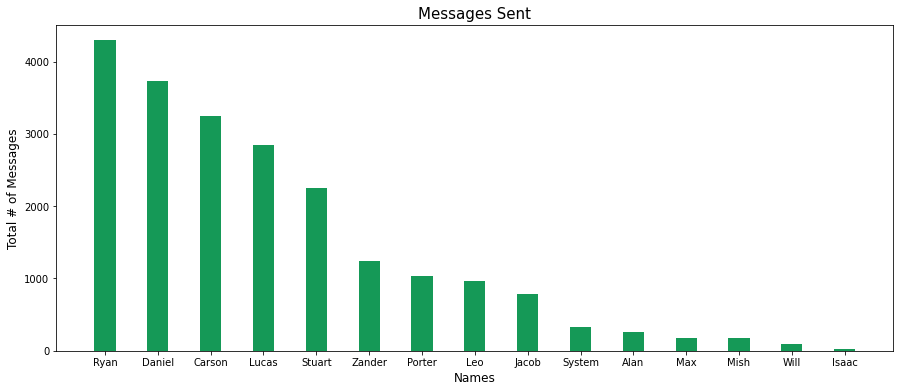

In [7]:
#Basic number of messages send

import matplotlib.pyplot as plt

vals = data['true_name'].value_counts()

plt.figure(figsize=(15, 6))
plt.title("Messages Sent", fontsize=15)
plt.ylabel("Total # of Messages", fontsize=12)
plt.xlabel("Names", fontsize=12)

plt.bar(x=vals.index, height=vals.values, width=.4, color=GREEN)
plt.show()

In [8]:
data[data["true_name"] == "Porter"].iloc[-1]['created_at']

Timestamp('2016-01-02 21:33:34')

In [9]:
#Cummulative Activity - Total messages over time in the group me 
#First get everyones start and end date - luckily it's sorted by time

start_end = {}
# print(data.true_name.eq("Lucas"))
for name in name_dict.keys():
    
    start_date = data[data["true_name"] == name].iloc[-1]['created_at']
    end_date = data[data["true_name"] == name].iloc[0]['created_at']
    
    delta = (end_date - start_date)
    start_end[name] = delta.days

print(start_end)


{'Porter': 1587, 'Stuart': 1616, 'Lucas': 1616, 'Zander': 1077, 'Ryan': 1616, 'Alan': 1616, 'Carson': 1616, 'Max': 1077, 'Mish': 1592, 'Will': 1135, 'Jacob': 1561, 'Daniel': 1357, 'Isaac': 703, 'Leo': 302, 'System': 1577}


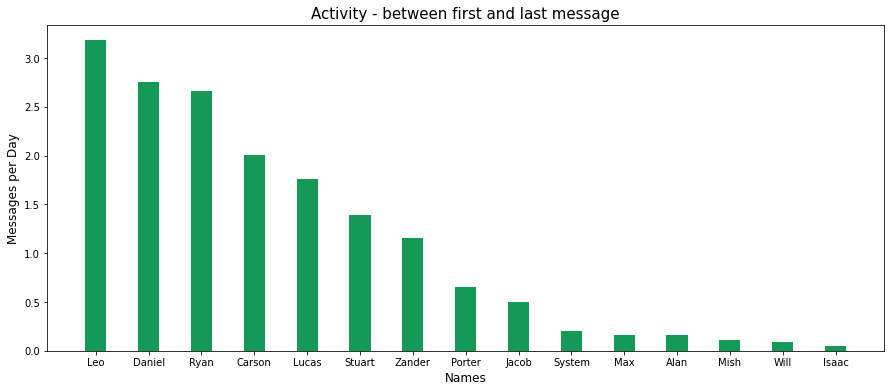

In [10]:
import matplotlib.pyplot as plt

vals = data['true_name'].value_counts()
activity = {}
for name in start_end.keys():
    activity[name] = vals[name] / start_end[name]
    
plt.figure(figsize=(15, 6))
plt.title("Activity - between first and last message", fontsize=15)
plt.ylabel("Messages per Day", fontsize=12)
plt.xlabel("Names", fontsize=12)

activity = {k: v for k, v in sorted(activity.items(), key=lambda item: item[1], reverse=True)}

plt.bar(x=activity.keys(), height=activity.values(), width=.4, color=GREEN)
plt.show()

In [11]:
data.iloc[-1]

attachments                                                    []
created_at                                    2015-12-04 18:32:23
favorited_by                                                   []
name                                                      GroupMe
sender_id                                                  system
sender_type                                                system
system                                                       True
text            Ryan Radulovacki added Lucas Mavromatis, Danie...
user_id                                                    system
true_name                                                  System
Name: 21494, dtype: object

In [12]:
#Lets get activity per person over time 

dti = pd.date_range('2015-12-01', periods=53, freq='M')    
dti

DatetimeIndex(['2015-12-31', '2016-01-31', '2016-02-29', '2016-03-31',
               '2016-04-30', '2016-05-31', '2016-06-30', '2016-07-31',
               '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
               '2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
               '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
               '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30',
               '2017-12-31', '2018-01-31', '2018-02-28', '2018-03-31',
               '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31',
               '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30',
               '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31',
               '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31',
               '2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30',
               '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30'],
              dtype='datetime64[ns]', freq='M')

In [13]:
from math import floor

data['year_month'] = data['created_at'].dt.floor('30D')
data['year'] = [date.year for date in data['created_at']]
data.head()

,attachments,created_at,favorited_by,name,sender_id,sender_type,system,text,user_id,true_name,year_month,year
0,[],2020-05-08 21:10:35,[],Porter Hunley,25416987,user,False,hang tonight?,25416987,Porter,2020-05-08,2020
1,[],2020-05-08 16:47:27,[25419093],Stuart Duffield,23024892,user,False,Scroll up,23024892,Stuart,2020-05-08,2020
2,[],2020-05-08 16:44:53,[],Lucas Mavromatis,19840057,user,False,neg,19840057,Lucas,2020-05-08,2020
3,[],2020-05-08 16:44:51,[],Lucas Mavromatis,19840057,user,False,porter are you nrg,19840057,Lucas,2020-05-08,2020
4,[],2020-05-08 16:40:27,"[24409684, 25416987]",Lucas Mavromatis,19840057,user,False,yeah im carded like half the time which makes ...,19840057,Lucas,2020-05-08,2020


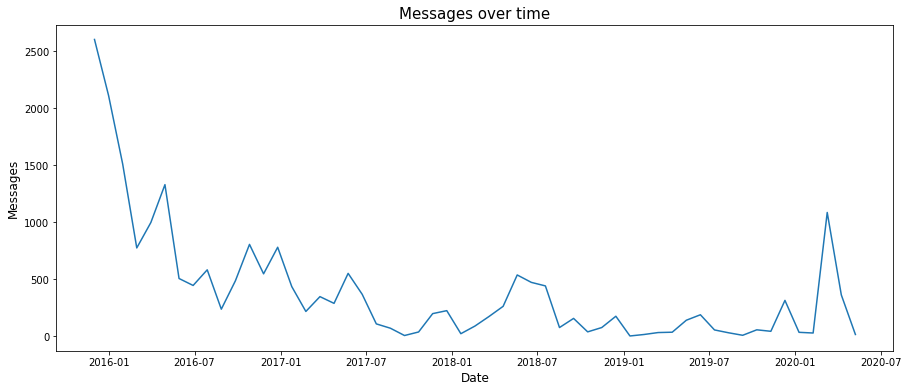

In [14]:
import matplotlib.pyplot as plt

vals = data['year_month'].value_counts().sort_index()

plt.figure(figsize=(15, 6))
plt.title("Messages over time", fontsize=15)
plt.ylabel("Messages", fontsize=12)
plt.xlabel("Date", fontsize=12)

plt.plot(vals.index, vals.values)
plt.show()

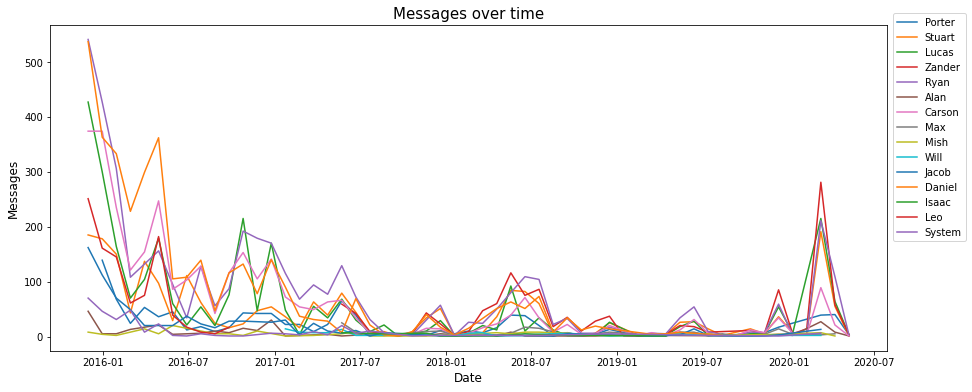

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.title("Messages over time", fontsize=15)
plt.ylabel("Messages", fontsize=12)
plt.xlabel("Date", fontsize=12)
    
for name in name_dict.keys():

    rows = data.loc[data['true_name'] == name]
    vals = rows['year_month'].value_counts().sort_index()

    plt.plot(vals.index, vals.values)
plt.legend(name_dict.keys(), bbox_to_anchor=(1.1, 1.05))
plt.show()

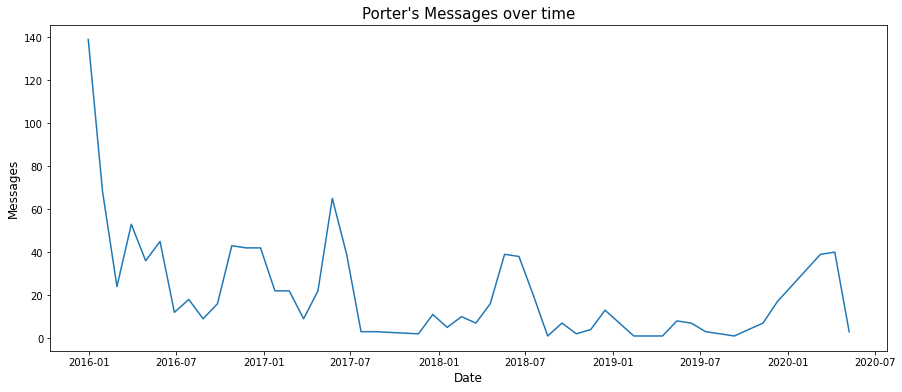

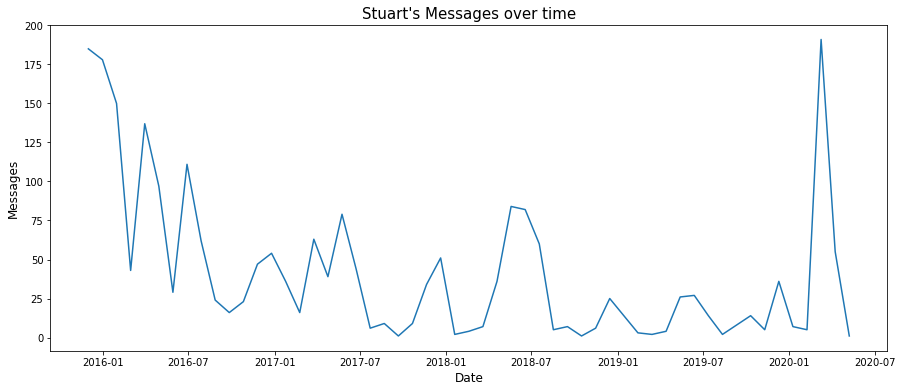

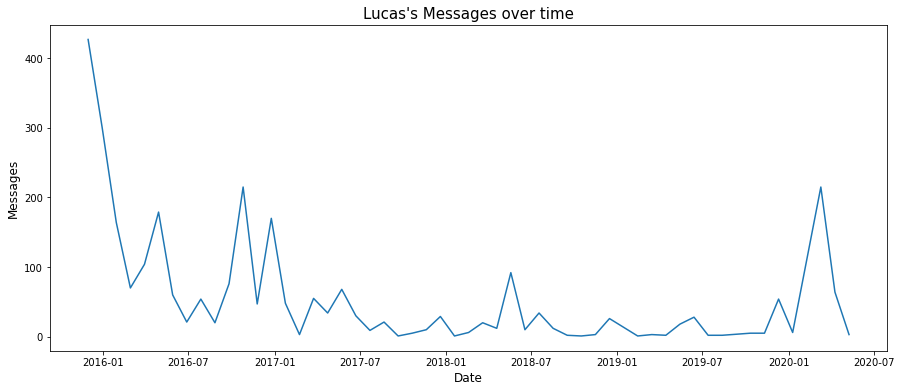

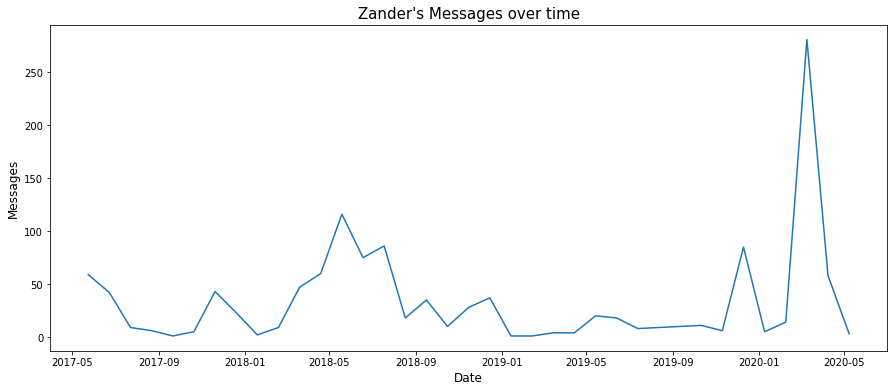

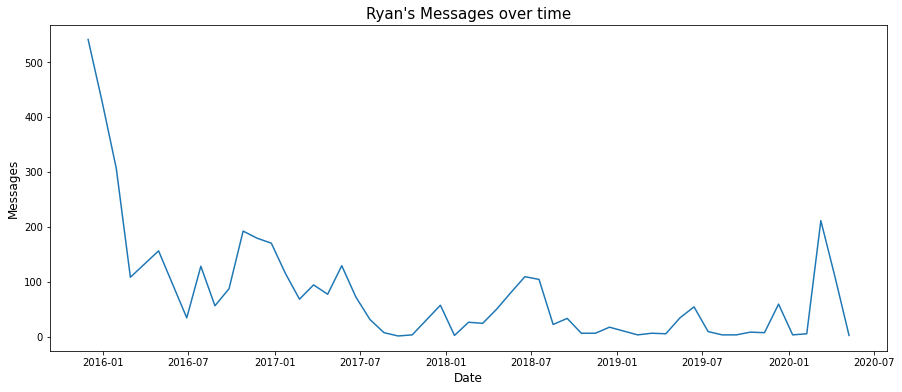

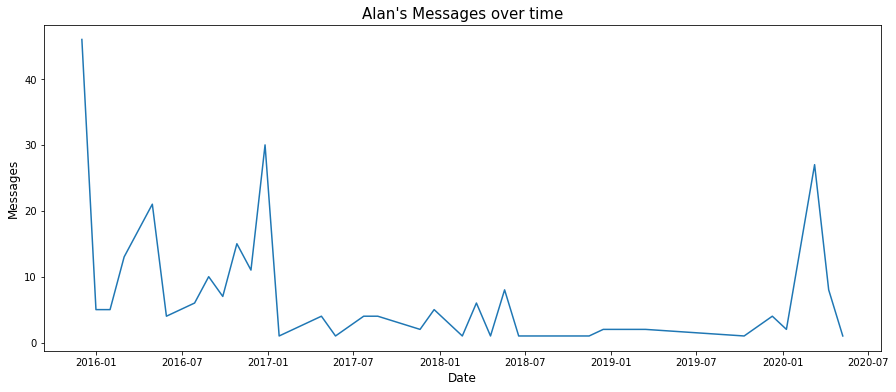

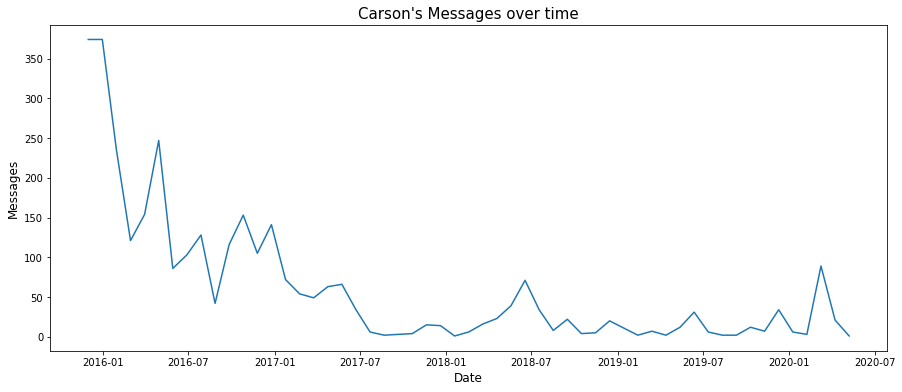

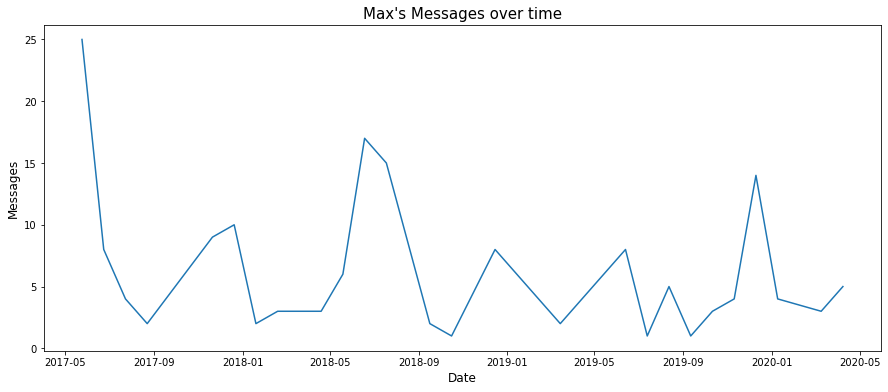

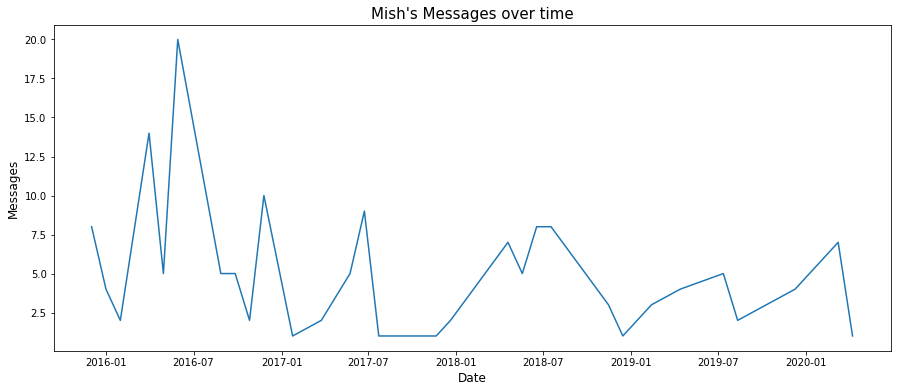

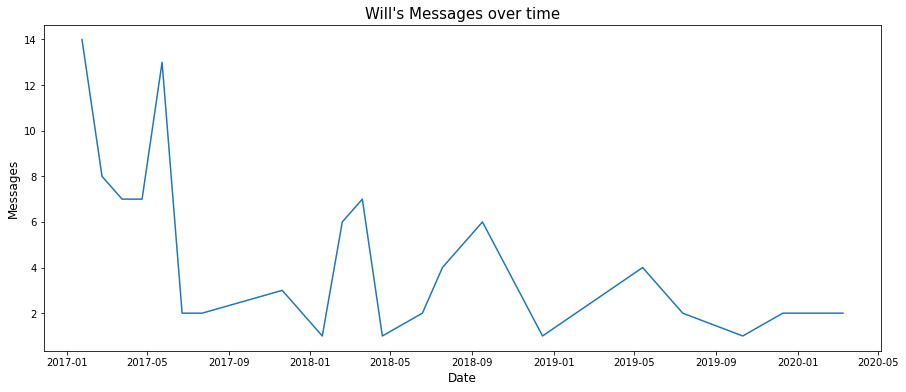

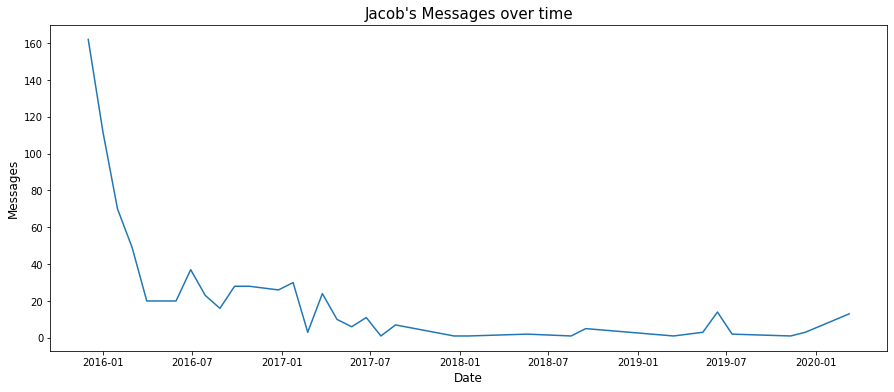

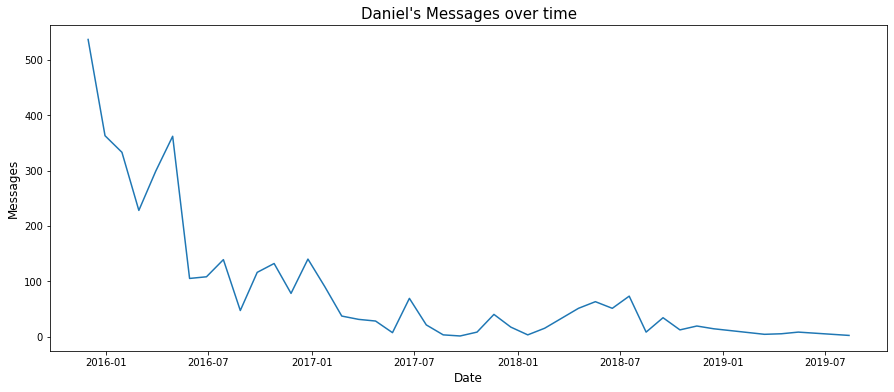

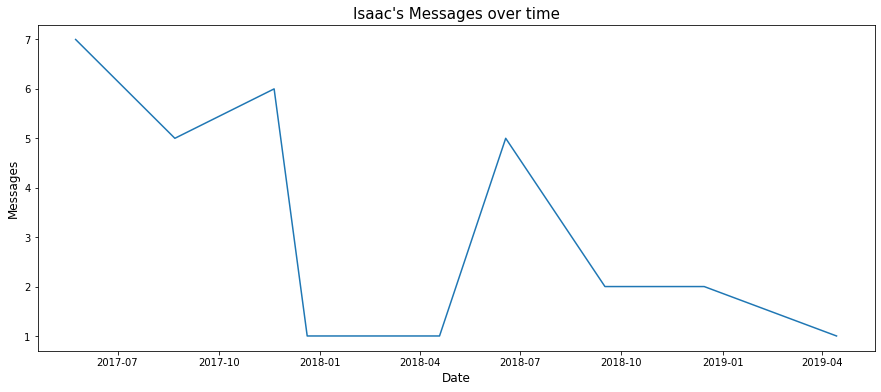

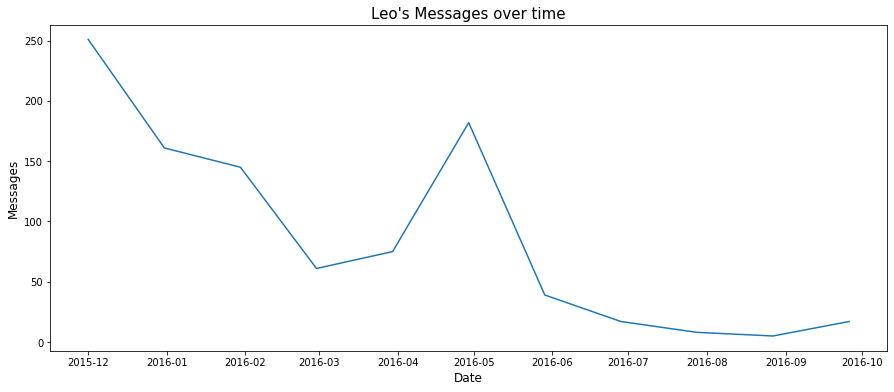

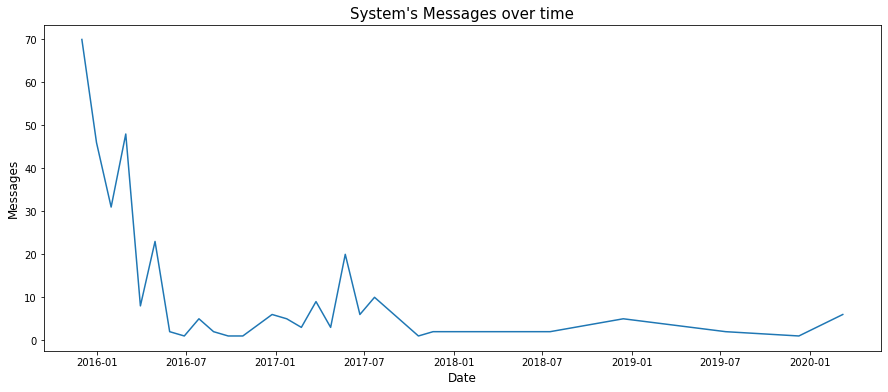

In [16]:
#Going through the true_name and getting the average monthly messages for each person
import matplotlib.pyplot as plt

for name in name_dict.keys():
    plt.figure(figsize=(15, 6))
    plt.title(name + "'s Messages over time", fontsize=15)
    plt.ylabel("Messages", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    
    
    rows = data.loc[data['true_name'] == name]
    vals = rows['year_month'].value_counts().sort_index()
    
    plt.plot(vals.index, vals.values)
    plt.show()


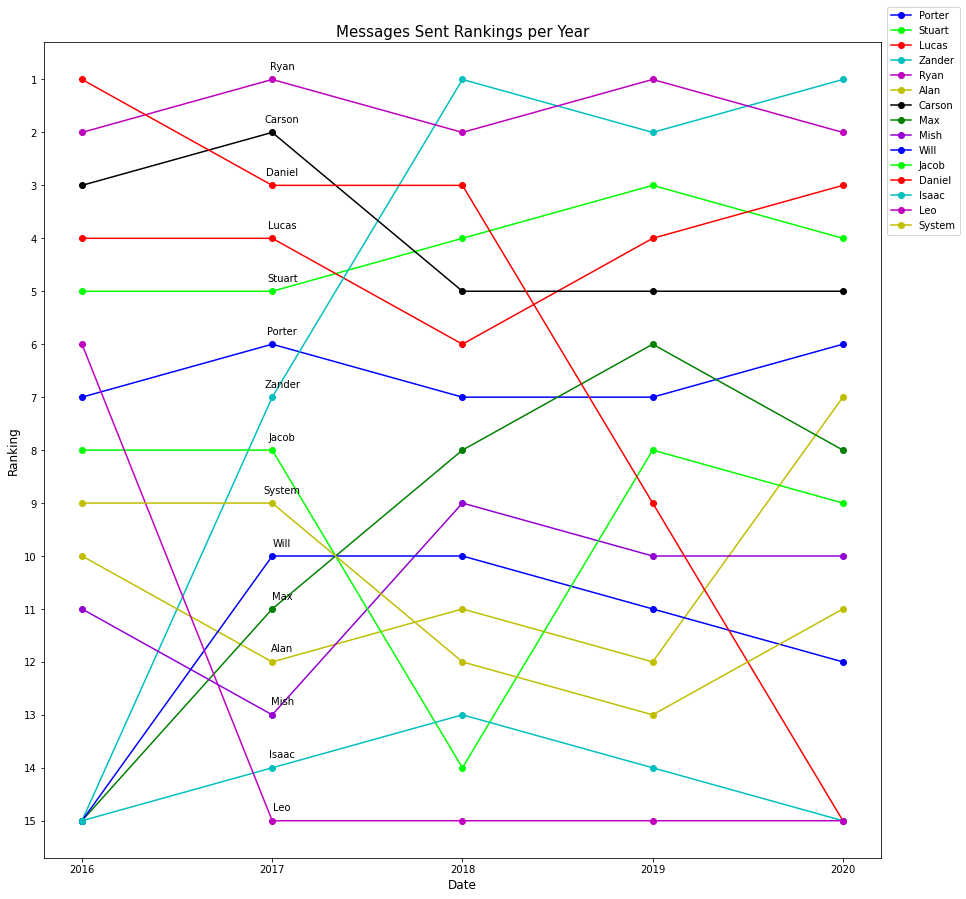

In [17]:
#Now getting the ranking for each person over time 
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
plt.title("Messages Sent Rankings per Year", fontsize=15)
plt.ylabel("Ranking", fontsize=12)
plt.xlabel("Date", fontsize=12)

# month_vals = data['year_month'].value_counts().sort_index()
years = pd.date_range('2016-01-01', periods=5, freq='Y')

#Every year we need the ranking of each person 
rank_dict = {}
# print(data['year_month'])
colors = ['b', 'lime', 'r', 'c', 'm', 'y', 'k', 'g', 'darkviolet']
for year in years:

    rows = data.loc[data['year'] == year.year]
    vals = rows['true_name'].value_counts()
    
    for name in name_dict.keys():
        #get ranking
        ranking = np.where(vals.index==name)[0] + 1
        if len(ranking) == 0:
            ranking = np.array([15])
            
        if name not in rank_dict:
            rank_dict[name] = []
        
        rank_dict[name].append(ranking.tolist()[0])
        
counter = 0
for name in name_dict.keys():
    plt.plot(['2016', '2017','2018','2019','2020'], rank_dict[name], color=colors[counter % (len(colors))], marker='o')
    counter+=1
    plt.annotate(name, # this is the text
            ('2017', rank_dict[name][1]), # this is the point to label
            textcoords="offset points", # how to position the text
            xytext=(10,10), # distance from text to points (x,y)
            ha='center') # horizontal alignment can be left, right or center



    
plt.yticks(range(15,0,-1))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.legend(name_dict.keys(), bbox_to_anchor=(1.1, 1.05))
plt.show()

### More Features
- People in group me 

In [18]:
#Let's see what the system messages say - people leaving the group?
sys_data = data[data['true_name'] == 'System']


In [19]:
words = ['removed', 'added']
rem = sys_data[sys_data['text'].str.contains('removed')]
add = sys_data[sys_data['text'].str.contains('added')]
rem_add = pd.concat([rem, add]).sort_index()
rem_add.head()

,attachments,created_at,favorited_by,name,sender_id,sender_type,system,text,user_id,true_name,year_month,year
1077,[],2020-03-15 13:58:42,[],GroupMe,system,system,True,Stuart Duffield added Zander clay to the group.,system,System,2020-03-09,2020
1101,[],2020-03-15 13:24:04,"[22491676, 25419093]",GroupMe,system,system,True,Lucas Mavromatis removed Zander Clay from the ...,system,System,2020-03-09,2020
3989,[],2018-06-09 16:33:16,[],GroupMe,system,system,True,Lucas Mavromatis added Ryan Radulovacki to the...,system,System,2018-05-19,2018
4212,[],2018-05-31 23:44:32,"[23024892, 24409684, 25419093]",GroupMe,system,system,True,Porter Hunley removed Ryan from the group.,system,System,2018-05-19,2018
5467,[],2017-08-17 18:02:18,[19090345],GroupMe,system,system,True,Lucas Mavromatis added Zander Clay to the group.,system,System,2017-07-23,2017


In [20]:
#Get the last add_rem message per person
#Get the first add_rem per person

start_end = {}
# print(data.true_name.eq("Lucas"))
for name in name_dict.keys():
    if name != 'System':
        start_date = data[data["true_name"] == name].iloc[-1]['year_month']
        end_date = data[data["true_name"] == name].iloc[0]['year_month']

        start_end[name] = (start_date, end_date)

start_end['Max'] = start_end['Max'][0], pd.Timestamp(2020, 5, 8)
print(start_end)

{'Porter': (Timestamp('2015-12-31 00:00:00'), Timestamp('2020-05-08 00:00:00')), 'Stuart': (Timestamp('2015-12-01 00:00:00'), Timestamp('2020-05-08 00:00:00')), 'Lucas': (Timestamp('2015-12-01 00:00:00'), Timestamp('2020-05-08 00:00:00')), 'Zander': (Timestamp('2017-05-24 00:00:00'), Timestamp('2020-05-08 00:00:00')), 'Ryan': (Timestamp('2015-12-01 00:00:00'), Timestamp('2020-05-08 00:00:00')), 'Alan': (Timestamp('2015-12-01 00:00:00'), Timestamp('2020-05-08 00:00:00')), 'Carson': (Timestamp('2015-12-01 00:00:00'), Timestamp('2020-05-08 00:00:00')), 'Max': (Timestamp('2017-05-24 00:00:00'), Timestamp('2020-05-08 00:00:00')), 'Mish': (Timestamp('2015-12-01 00:00:00'), Timestamp('2020-04-08 00:00:00')), 'Will': (Timestamp('2017-01-24 00:00:00'), Timestamp('2020-03-09 00:00:00')), 'Jacob': (Timestamp('2015-12-01 00:00:00'), Timestamp('2020-03-09 00:00:00')), 'Daniel': (Timestamp('2015-12-01 00:00:00'), Timestamp('2019-08-12 00:00:00')), 'Isaac': (Timestamp('2017-05-24 00:00:00'), Timestam

In [21]:
#Lets get the percentage of messages sent during their time in the GroupMe

percent_message_sent = {}
for name in name_dict.keys():
    if name == 'System':
        continue
    
    #get duration 
    rows = data[(data['year_month'] > start_end[name][0]) & (data['year_month'] < start_end[name][1])]
    sent = len(rows[rows['true_name']==name].index)
    total_sent = len(rows.index)
    
    
    percent_message_sent[name] = sent / total_sent
    
percent_message_sent
    

{'Porter': 0.05341139921137531,
 'Stuart': 0.10972568578553615,
 'Lucas': 0.12824322173290179,
 'Zander': 0.1988511572900828,
 'Ryan': 0.19907677614474453,
 'Alan': 0.011513768769565448,
 'Carson': 0.1522258184326418,
 'Max': 0.025848960973137353,
 'Mish': 0.008871578491831657,
 'Will': 0.013791929167376128,
 'Jacob': 0.03488104815538444,
 'Daniel': 0.18909801136363635,
 'Isaac': 0.006471581316826111,
 'Leo': 0.08171206225680934}

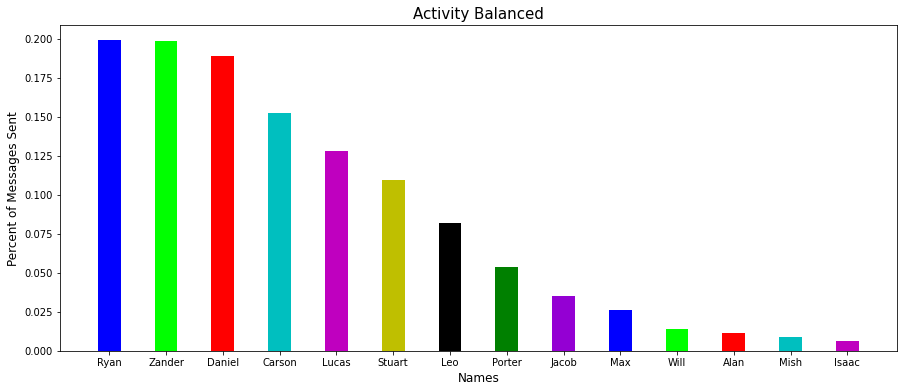

In [22]:
#Now plot the results 
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.title("Activity Balanced", fontsize=15)
plt.ylabel("Percent of Messages Sent", fontsize=12)
plt.xlabel("Names", fontsize=12)

percent_message_sent = {k: v for k, v in sorted(percent_message_sent.items(), key=lambda item: item[1], reverse=True)}

plt.bar(x=percent_message_sent.keys(), height=percent_message_sent.values(), width=.4, color=COLORS)
plt.show()

In [23]:
def get_num_people(timestamp):
    in_chat = []
    for name in start_end.keys():
        start = start_end[name][0]
        end = start_end[name][1]
        
        if timestamp >= start and timestamp <= end:
            in_chat.append(name)
    return in_chat

In [24]:
data['in_chat'] = data['year_month'].apply(get_num_people)
data.head()

,attachments,created_at,favorited_by,name,sender_id,sender_type,system,text,user_id,true_name,year_month,year,in_chat
0,[],2020-05-08 21:10:35,[],Porter Hunley,25416987,user,False,hang tonight?,25416987,Porter,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca..."
1,[],2020-05-08 16:47:27,[25419093],Stuart Duffield,23024892,user,False,Scroll up,23024892,Stuart,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca..."
2,[],2020-05-08 16:44:53,[],Lucas Mavromatis,19840057,user,False,neg,19840057,Lucas,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca..."
3,[],2020-05-08 16:44:51,[],Lucas Mavromatis,19840057,user,False,porter are you nrg,19840057,Lucas,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca..."
4,[],2020-05-08 16:40:27,"[24409684, 25416987]",Lucas Mavromatis,19840057,user,False,yeah im carded like half the time which makes ...,19840057,Lucas,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca..."


In [25]:
data['num_active'] = data['in_chat'].apply(len)
data

,attachments,created_at,favorited_by,name,sender_id,sender_type,system,text,user_id,true_name,year_month,year,in_chat,num_active
0,[],2020-05-08 21:10:35,[],Porter Hunley,25416987,user,False,hang tonight?,25416987,Porter,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8
1,[],2020-05-08 16:47:27,[25419093],Stuart Duffield,23024892,user,False,Scroll up,23024892,Stuart,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8
2,[],2020-05-08 16:44:53,[],Lucas Mavromatis,19840057,user,False,neg,19840057,Lucas,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8
3,[],2020-05-08 16:44:51,[],Lucas Mavromatis,19840057,user,False,porter are you nrg,19840057,Lucas,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8
4,[],2020-05-08 16:40:27,"[24409684, 25416987]",Lucas Mavromatis,19840057,user,False,yeah im carded like half the time which makes ...,19840057,Lucas,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21490,"[{'loci': [[0, 17]], 'type': 'mentions', 'user...",2015-12-04 18:33:09,[],Ryan Radulovacki,22491676,user,False,@Lucas Mavromatis Needs to make his,22491676,Ryan,2015-12-01,2015,"[Stuart, Lucas, Ryan, Alan, Carson, Mish, Jaco...",9
21491,[],2015-12-04 18:33:04,[],Ryan Radulovacki,22491676,user,False,Because we're doing group mes for each of our ...,22491676,Ryan,2015-12-01,2015,"[Stuart, Lucas, Ryan, Alan, Carson, Mish, Jaco...",9
21492,[],2015-12-04 18:32:48,[],Daniel Fridkin,19090345,user,False,I still don't understand why this is necessary,19090345,Daniel,2015-12-01,2015,"[Stuart, Lucas, Ryan, Alan, Carson, Mish, Jaco...",9
21493,[],2015-12-04 18:32:30,[],Ryan Radulovacki,22491676,user,False,Starting w the men,22491676,Ryan,2015-12-01,2015,"[Stuart, Lucas, Ryan, Alan, Carson, Mish, Jaco...",9


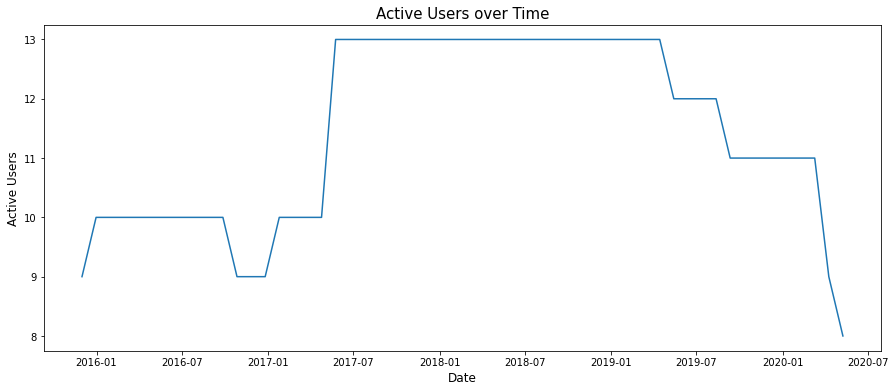

In [26]:
#Active users over time
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.title("Active Users over Time", fontsize=15)
plt.ylabel("Active Users", fontsize=12)
plt.xlabel("Date", fontsize=12)

dates = data['year_month'].value_counts().sort_index()
actives = []
for date in dates.index:

    actives.append(data.loc[data['year_month'] == date].iloc[0]['num_active'])
    
plt.plot(dates.index, actives)
plt.show()

### Likes
- Who gives the most likes?
- Who gets the most likes?
- Who has the highest number of likes per message?
- What messsages have the most likes?
- What goes into a message with a lot of likes?

In [27]:
data.head()

,attachments,created_at,favorited_by,name,sender_id,sender_type,system,text,user_id,true_name,year_month,year,in_chat,num_active
0,[],2020-05-08 21:10:35,[],Porter Hunley,25416987,user,False,hang tonight?,25416987,Porter,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8
1,[],2020-05-08 16:47:27,[25419093],Stuart Duffield,23024892,user,False,Scroll up,23024892,Stuart,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8
2,[],2020-05-08 16:44:53,[],Lucas Mavromatis,19840057,user,False,neg,19840057,Lucas,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8
3,[],2020-05-08 16:44:51,[],Lucas Mavromatis,19840057,user,False,porter are you nrg,19840057,Lucas,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8
4,[],2020-05-08 16:40:27,"[24409684, 25416987]",Lucas Mavromatis,19840057,user,False,yeah im carded like half the time which makes ...,19840057,Lucas,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8


In [28]:
#Create like count feature
data['like_count'] = data['favorited_by'].apply(len)
data.head()

,attachments,created_at,favorited_by,name,sender_id,sender_type,system,text,user_id,true_name,year_month,year,in_chat,num_active,like_count
0,[],2020-05-08 21:10:35,[],Porter Hunley,25416987,user,False,hang tonight?,25416987,Porter,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8,0
1,[],2020-05-08 16:47:27,[25419093],Stuart Duffield,23024892,user,False,Scroll up,23024892,Stuart,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8,1
2,[],2020-05-08 16:44:53,[],Lucas Mavromatis,19840057,user,False,neg,19840057,Lucas,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8,0
3,[],2020-05-08 16:44:51,[],Lucas Mavromatis,19840057,user,False,porter are you nrg,19840057,Lucas,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8,0
4,[],2020-05-08 16:40:27,"[24409684, 25416987]",Lucas Mavromatis,19840057,user,False,yeah im carded like half the time which makes ...,19840057,Lucas,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8,2


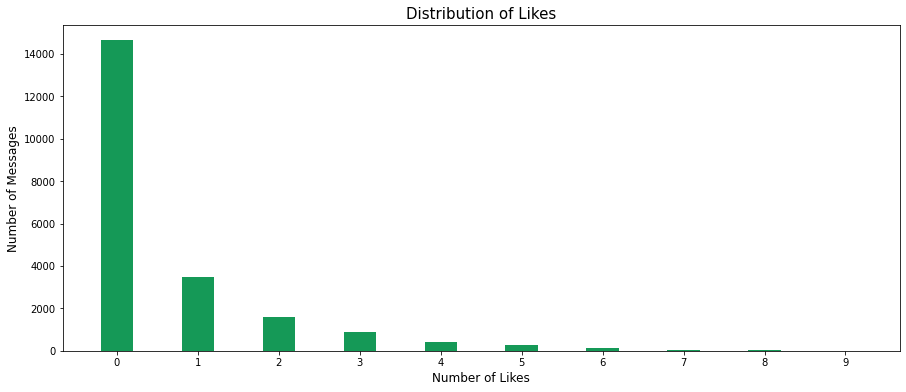

In [29]:
#Like distribution of 

import matplotlib.pyplot as plt

vals = data['like_count'].value_counts()

plt.figure(figsize=(15, 6))
plt.title("Distribution of Likes", fontsize=15)
plt.ylabel("Number of Messages", fontsize=12)
plt.xlabel("Number of Likes", fontsize=12)
plt.xticks(range(0,10,1))

plt.bar(x=vals.index, height=vals.values, width=.4, color=GREEN)
plt.show()


In [30]:
#Liked data
liked_data = data[data['like_count'] > 0]
liked_messages = liked_data[['text', 'like_count', 'true_name', 'attachments', 'in_chat', 'num_active', 'favorited_by', 'year_month', 'created_at']]
liked_messages = liked_messages.sort_values(by=['like_count'], ascending=False)

In [76]:
### Plotting the n most liked messages
liked_messages.iloc[0:20]

,text,like_count,true_name,attachments,in_chat,num_active,favorited_by,year_month,created_at,percent_like,...,Ryan_liked,Alan_liked,Carson_liked,Max_liked,Mish_liked,Will_liked,Jacob_liked,Daniel_liked,Isaac_liked,Leo_liked
2848,"We love you man, hang in there",9,Carson,[],"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Daniel, Isaac, Lucas, Ryan, Jacob, Zander, Porter, Will, Max]",2018-09-16,2018-09-23 04:35:33,0.692308,...,True,False,False,True,False,True,True,True,True,False
2381,@Carson you look handsome in that yearbook pic,9,Jacob,"[{'loci': [[0, 7]], 'type': 'mentions', 'user_ids': ['25419093']}]","[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Lucas, Alan, Ryan, Stuart, Zander, Porter, Will, Carson, Max]",2019-03-15,2019-03-22 15:45:09,0.692308,...,True,True,True,True,False,True,False,False,False,False
4194,im a yellow jacket now,9,Porter,[],"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Daniel, Isaac, Lucas, Stuart, Zander, Mish, Will, Carson, Max]",2018-05-19,2018-06-01 21:07:20,0.692308,...,False,False,True,True,True,True,False,True,True,False
7239,tfw,9,Daniel,"[{'type': 'image', 'url': 'https://i.groupme.com/722x1280.jpeg.cfdb63b390b24f55998be4974aa75732'}]","[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mish, Will, Jacob, Daniel]",10,"[Daniel, Lucas, Alan, Ryan, Stuart, Jacob, Porter, Will, Carson]",2017-02-23,2017-03-11 16:35:40,0.900000,...,True,True,True,False,False,True,True,True,False,False
2378,Spotted at Lenox https://v.groupme.com/18315642/2019-05-05T18:43:21Z/1edbc4b.568x320r90.mp4,9,Porter,"[{'preview_url': 'https://v.groupme.com/18315642/2019-05-05T18:43:21Z/1edbc4b.568x320r90.jpg', 'type': 'video', 'url': 'https://v.groupme.com/18315642/2019-05-05T18:43:21Z/1edbc4b.568x320r90.mp4'}]","[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Daniel, Isaac, Lucas, Ryan, Jacob, Zander, Will, Carson, Max]",2019-04-14,2019-05-05 18:43:32,0.692308,...,True,False,True,True,False,True,True,True,True,False
5014,Happy birthday? @Daniel,8,Ryan,"[{'loci': [[16, 7]], 'type': 'mentions', 'user_ids': ['19090345']}]","[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Daniel, Lucas, Stuart, Zander, Porter, Will, Carson, Max]",2017-12-20,2018-01-06 22:37:44,0.615385,...,False,False,True,True,False,True,False,True,False,False
2604,Seeing Lagos on TV 👀,8,Alan,[],"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Daniel, Lucas, Stuart, Jacob, Zander, Will, Carson, Max]",2018-11-15,2018-12-09 03:10:44,0.615385,...,False,False,True,True,False,True,True,True,False,False
18371,None,8,Stuart,"[{'type': 'image', 'url': 'https://i.groupme.com/1125x1500.jpeg.ac9697d26dda4ac88c6848bd489d3475'}]","[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mish, Jacob, Daniel, Leo]",10,"[Daniel, Lucas, Leo, Ryan, Stuart, Jacob, Porter, Carson]",2015-12-31,2016-01-07 02:25:43,0.800000,...,True,False,True,False,False,False,True,True,False,True
17970,Cunts,8,Stuart,"[{'type': 'image', 'url': 'https://i.groupme.com/1125x1500.jpeg.f22b6b2818f6416db20eae0d130968b4'}]","[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mish, Jacob, Daniel, Leo]",10,"[Daniel, Lucas, Leo, Ryan, Stuart, Jacob, Porter, Carson]",2015-12-31,2016-01-09 19:55:00,0.800000,...,True,False,True,False,False,False,True,True,False,True
2605,ATL HO,8,Lucas,[],"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Daniel, Ryan, Stuart, Jacob, Zander, Will, Carson, Max]",2018-11-15,2018-12-09 03:10:27,0.615385,...,True,False,True,True,False,True,True,True,False,False


In [ ]:
liked_messages[]

In [32]:
#Like percentage of groupMe
liked_messages['percent_like'] = liked_messages['like_count'] / liked_messages['num_active']

In [33]:
liked_messages.sort_values(by=['percent_like'], ascending=False).iloc[0:20]

,text,like_count,true_name,attachments,in_chat,num_active,favorited_by,year_month,created_at,percent_like
7239,tfw,9,Daniel,"[{'type': 'image', 'url': 'https://i.groupme.c...","[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mi...",10,"[19090345, 19840057, 19844543, 22491676, 23024...",2017-02-23,2017-03-11 16:35:40,0.900000
18587,Hey boys I got my phone stolen but now I got a...,8,Alan,[],"[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mi...",10,"[19090345, 19840057, 22241097, 22491676, 23024...",2015-12-31,2016-01-02 22:55:45,0.800000
18371,None,8,Stuart,"[{'type': 'image', 'url': 'https://i.groupme.c...","[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mi...",10,"[19090345, 19840057, 22241097, 22491676, 23024...",2015-12-31,2016-01-07 02:25:43,0.800000
17970,Cunts,8,Stuart,"[{'type': 'image', 'url': 'https://i.groupme.c...","[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mi...",10,"[19090345, 19840057, 22241097, 22491676, 23024...",2015-12-31,2016-01-09 19:55:00,0.800000
13,I don’t have covid,6,Porter,[],"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8,"[19840057, 22491676, 23024892, 24409684, 25419...",2020-05-08,2020-05-08 15:50:02,0.750000
1843,Are people in Atlanta winter break,8,Lucas,[],"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",11,"[19844543, 22491676, 23024892, 24409684, 25416...",2019-11-10,2019-12-01 01:42:17,0.727273
15951,Gilbert Arenas is being investigated for fraud...,7,Jacob,"[{'type': 'image', 'url': 'https://i.groupme.c...","[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mi...",10,"[19090345, 19840057, 22241097, 22491676, 23024...",2016-01-30,2016-02-18 03:23:13,0.700000
18326,My parents might disown me if they see that,7,Porter,[],"[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mi...",10,"[19090345, 19840057, 22241097, 22491676, 23024...",2015-12-31,2016-01-08 01:12:03,0.700000
7076,"In the email it literally said ""We appreciate ...",7,Ryan,[],"[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mi...",10,"[19090345, 19844543, 23024892, 23024901, 25416...",2017-03-25,2017-03-30 21:15:05,0.700000
17310,She was just saying how she only likes people ...,7,Lucas,[],"[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mi...",10,"[19090345, 22241097, 22491676, 23024892, 23024...",2015-12-31,2016-01-16 04:09:54,0.700000


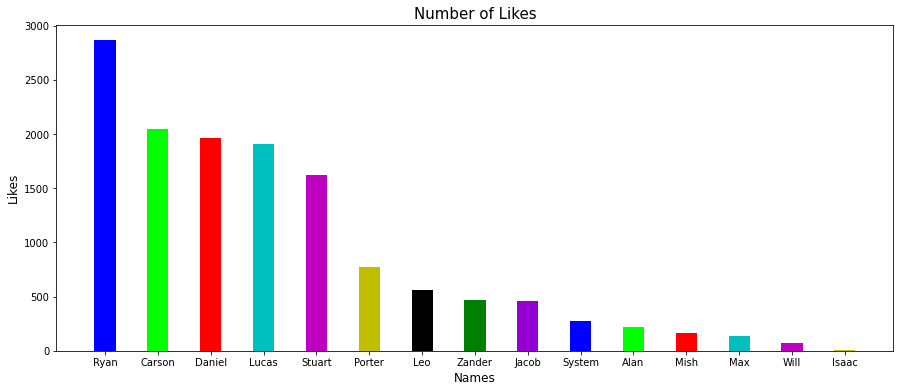

In [34]:
#Person with the most straight up likes
import matplotlib.pyplot as plt

likes = {}
for name in name_dict.keys():
    rows = data[data['true_name'] == name]
    likes[name] = rows['like_count'].sum()
    
    
plt.figure(figsize=(15, 6))
plt.title("Number of Likes", fontsize=15)
plt.ylabel("Likes", fontsize=12)
plt.xlabel("Names", fontsize=12)

likes = {k: v for k, v in sorted(likes.items(), key=lambda item: item[1], reverse=True)}

plt.bar(x=likes.keys(), height=likes.values(), width=.4, color=COLORS)
plt.show()

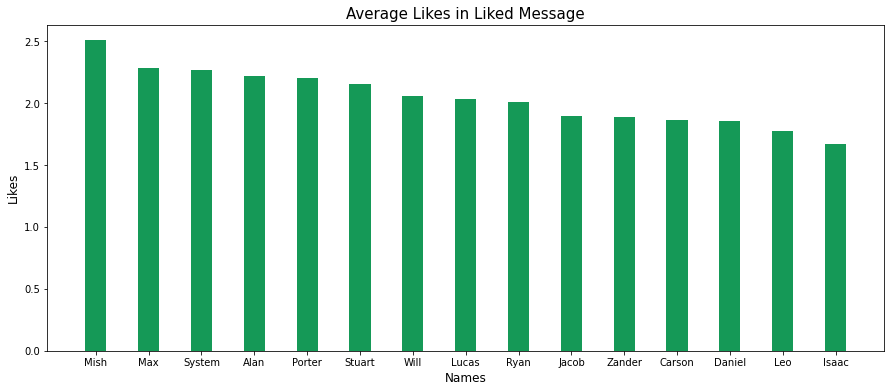

In [35]:
#Highest Average Likes
import matplotlib.pyplot as plt

med_likes = {}
for name in name_dict.keys():
    rows = liked_messages[liked_messages['true_name'] == name]
    med_likes[name] = rows['like_count'].mean()
    
    
plt.figure(figsize=(15, 6))
plt.title("Average Likes in Liked Message", fontsize=15)
plt.ylabel("Likes", fontsize=12)
plt.xlabel("Names", fontsize=12)

med_likes = {k: v for k, v in sorted(med_likes.items(), key=lambda item: item[1], reverse=True)}

plt.bar(x=med_likes.keys(), height=med_likes.values(), width=.4, color=GREEN)
plt.show()

{'Porter': 0.747104247104247, 'Stuart': 0.7209405501330968, 'Lucas': 0.6708816297857394, 'Zander': 0.3744955609362389, 'Ryan': 0.6670547147846333, 'Alan': 0.8484848484848485, 'Carson': 0.6297780517879161, 'Max': 0.7696629213483146, 'Mish': 0.9421965317919075, 'Will': 0.7628865979381443, 'Jacob': 0.5856777493606138, 'Daniel': 0.5257096946973755, 'Isaac': 0.3225806451612903, 'Leo': 0.5827263267429761}


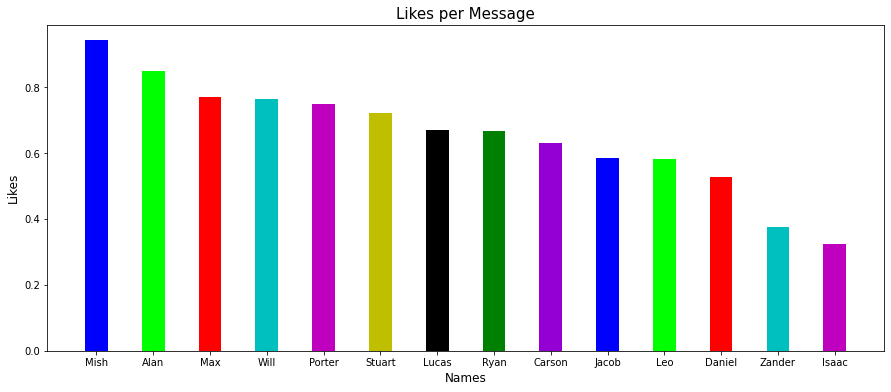

In [36]:
#Highest Average Likes
import matplotlib.pyplot as plt

message_likes = {}
for name in name_dict.keys():
    if name != 'System':
        rows = data[data['true_name'] == name]
        message_likes[name] = rows['like_count'].sum() / len(rows)

print(message_likes)
plt.figure(figsize=(15, 6))
plt.title("Likes per Message", fontsize=15)
plt.ylabel("Likes", fontsize=12)
plt.xlabel("Names", fontsize=12)

message_likes = {k: v for k, v in sorted(message_likes.items(), key=lambda item: item[1], reverse=True)}

plt.bar(x=message_likes.keys(), height=message_likes.values(), width=.4, color=COLORS)
plt.show()

In [37]:
#Who has given the most likes?? This requires us to to revist the original data
data['favorited_by'] = data['favorited_by'].apply(lambda x: [id_to_name[y] for y in x])
data.head()

,attachments,created_at,favorited_by,name,sender_id,sender_type,system,text,user_id,true_name,year_month,year,in_chat,num_active,like_count
0,[],2020-05-08 21:10:35,[],Porter Hunley,25416987,user,False,hang tonight?,25416987,Porter,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8,0
1,[],2020-05-08 16:47:27,[Carson],Stuart Duffield,23024892,user,False,Scroll up,23024892,Stuart,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8,1
2,[],2020-05-08 16:44:53,[],Lucas Mavromatis,19840057,user,False,neg,19840057,Lucas,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8,0
3,[],2020-05-08 16:44:51,[],Lucas Mavromatis,19840057,user,False,porter are you nrg,19840057,Lucas,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8,0
4,[],2020-05-08 16:40:27,"[Zander, Porter]",Lucas Mavromatis,19840057,user,False,yeah im carded like half the time which makes ...,19840057,Lucas,2020-05-08,2020,"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Ca...",8,2


In [38]:
#Counting number of times each person liked something 
def count_favs(fav_list, count_dict):
    for name in fav_list:
        if name not in count_dict:
            count_dict[name] = 0
        count_dict[name]+=1

count_dict = {}
data['favorited_by'].apply(lambda x: count_favs(x,count_dict))
count_dict

{'Carson': 2156,
 'Zander': 674,
 'Porter': 1258,
 'Lucas': 1574,
 'Ryan': 1767,
 'Max': 206,
 'Stuart': 1146,
 'Alan': 198,
 'Mish': 63,
 'Jacob': 664,
 'Will': 303,
 'Daniel': 2471,
 'Isaac': 21,
 'Leo': 1041}

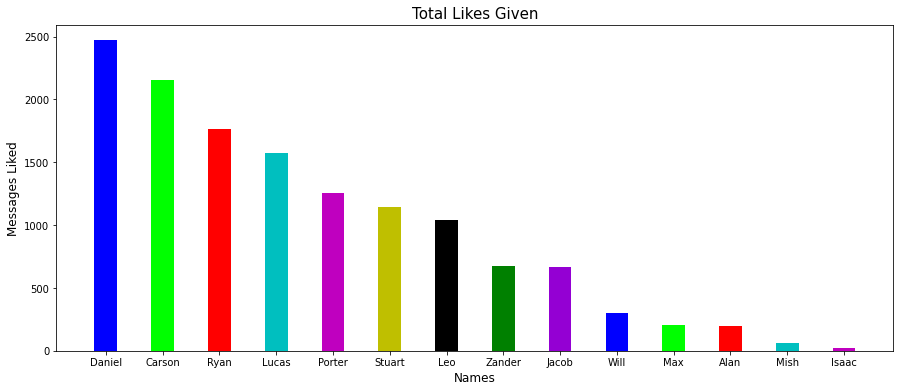

In [39]:
#Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.title("Total Likes Given", fontsize=15)
plt.ylabel("Messages Liked", fontsize=12)
plt.xlabel("Names", fontsize=12)

count_dict = {k: v for k, v in sorted(count_dict.items(), key=lambda item: item[1], reverse=True)}

plt.bar(x=count_dict.keys(), height=count_dict.values(), width=.4, color=COLORS)
plt.show()


In [40]:
#Days active in group
days_active = {}
for name in start_end.keys():
    days_active[name] = (start_end[name][1] - start_end[name][0]).days

days_active

{'Porter': 1590,
 'Stuart': 1620,
 'Lucas': 1620,
 'Zander': 1080,
 'Ryan': 1620,
 'Alan': 1620,
 'Carson': 1620,
 'Max': 1080,
 'Mish': 1590,
 'Will': 1140,
 'Jacob': 1560,
 'Daniel': 1350,
 'Isaac': 690,
 'Leo': 300}

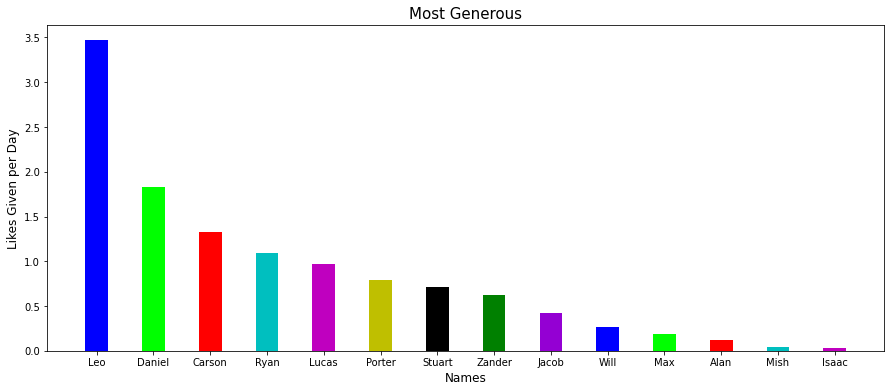

In [42]:
#Likes given per day
#Plot the results
import matplotlib.pyplot as plt

likes_per_day = {}
for name in days_active.keys():
    likes_per_day[name] = count_dict[name] / days_active[name]

plt.figure(figsize=(15, 6))
plt.title("Most Generous", fontsize=15)
plt.ylabel("Likes Given per Day", fontsize=12)
plt.xlabel("Names", fontsize=12)

likes_per_day = {k: v for k, v in sorted(likes_per_day.items(), key=lambda item: item[1], reverse=True)}

plt.bar(x=likes_per_day.keys(), height=likes_per_day.values(), width=.4, color=COLORS)
plt.show()


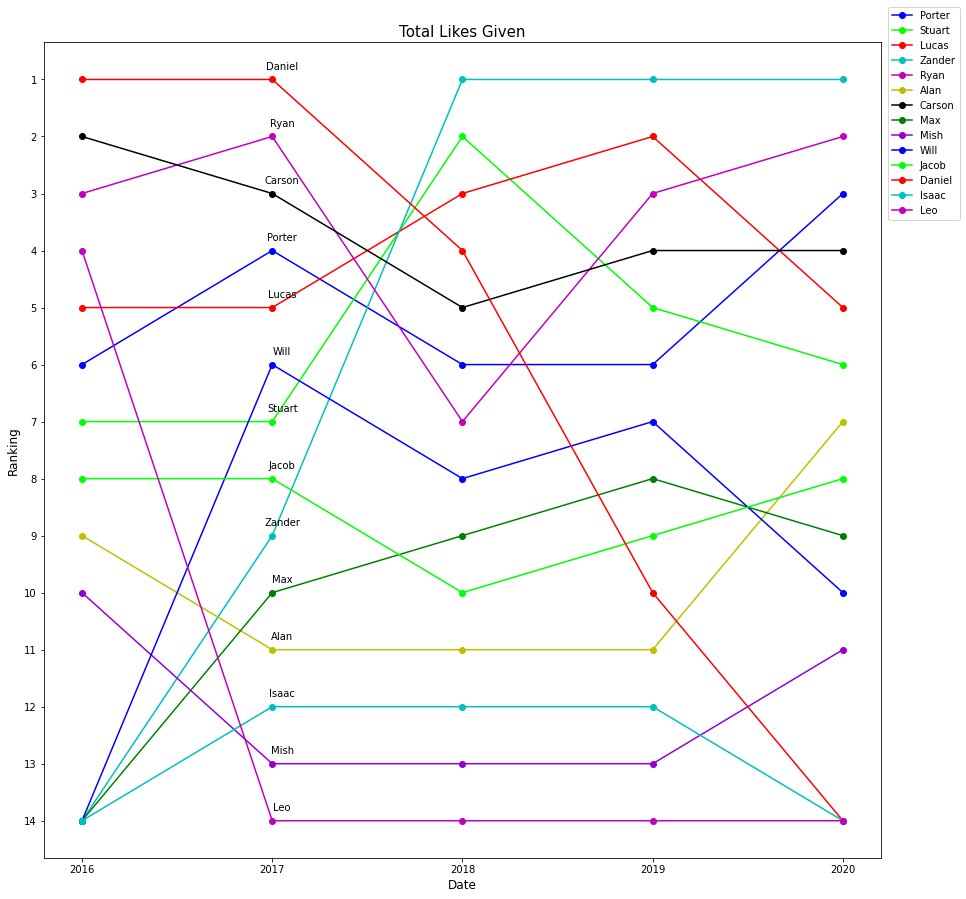

In [43]:
#Let's do a most generous over time 
#Now getting the ranking for each person over time 
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
plt.title("Total Likes Given", fontsize=15)
plt.ylabel("Ranking", fontsize=12)
plt.xlabel("Date", fontsize=12)

# month_vals = data['year_month'].value_counts().sort_index()
years = pd.date_range('2016-01-01', periods=5, freq='Y')

#Every year we need the ranking of each person 
rank_dict = {}
# print(data['year_month'])
colors = ['b', 'lime', 'r', 'c', 'm', 'y', 'k', 'g', 'darkviolet']
for year in years:

    rows = data.loc[data['year'] == year.year]
    c_dict = {}
    
    #Now count the number of likes
    rows['favorited_by'].apply(lambda x: count_favs(x,c_dict))
    
    c_dict = {k: v for k, v in sorted(c_dict.items(), key=lambda item: item[1], reverse=True)}
    
    for name in name_dict.keys():
        if name == 'System':
            continue
            
        #get ranking
        try:
            ranking = list(c_dict.keys()).index(name) + 1
    
        except ValueError:
            ranking = 14
            
        if name not in rank_dict:
            rank_dict[name] = []
        
        rank_dict[name].append(ranking)
        
counter = 0
for name in name_dict.keys():
    if name == 'System':
        continue
    plt.plot(['2016', '2017','2018','2019','2020'], rank_dict[name], color=colors[counter % (len(colors))], marker='o')
    counter+=1
    plt.annotate(name, # this is the text
            ('2017', rank_dict[name][1]), # this is the point to label
            textcoords="offset points", # how to position the text
            xytext=(10,10), # distance from text to points (x,y)
            ha='center') # horizontal alignment can be left, right or center



    
plt.yticks(range(14,0,-1))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.legend(name_dict.keys(), bbox_to_anchor=(1.1, 1.05))
plt.show()

In [44]:
#Leo's high ranking is suspicious - let's see the overall rate of liking as time goes on
#Average likes per message per month 

like_rate = {}
for date in data['year_month'].value_counts().sort_index().index:
    time_data = data[data['year_month'] == date]
    like_rate[date] = time_data['like_count'].mean()
like_rate
    

{Timestamp('2015-12-01 00:00:00'): 0.6651287966166859,
 Timestamp('2015-12-31 00:00:00'): 0.7814129919393077,
 Timestamp('2016-01-30 00:00:00'): 0.7607687210072896,
 Timestamp('2016-02-29 00:00:00'): 0.6636481241914618,
 Timestamp('2016-03-30 00:00:00'): 0.5943775100401606,
 Timestamp('2016-04-29 00:00:00'): 0.661144578313253,
 Timestamp('2016-05-29 00:00:00'): 0.5881188118811881,
 Timestamp('2016-06-28 00:00:00'): 0.4144144144144144,
 Timestamp('2016-07-28 00:00:00'): 0.5456110154905336,
 Timestamp('2016-08-27 00:00:00'): 0.5635593220338984,
 Timestamp('2016-09-26 00:00:00'): 0.40824742268041236,
 Timestamp('2016-10-26 00:00:00'): 0.43781094527363185,
 Timestamp('2016-11-25 00:00:00'): 0.5641025641025641,
 Timestamp('2016-12-25 00:00:00'): 0.42618741976893454,
 Timestamp('2017-01-24 00:00:00'): 0.47465437788018433,
 Timestamp('2017-02-23 00:00:00'): 0.8333333333333334,
 Timestamp('2017-03-25 00:00:00'): 0.6127167630057804,
 Timestamp('2017-04-24 00:00:00'): 0.519163763066202,
 Timesta

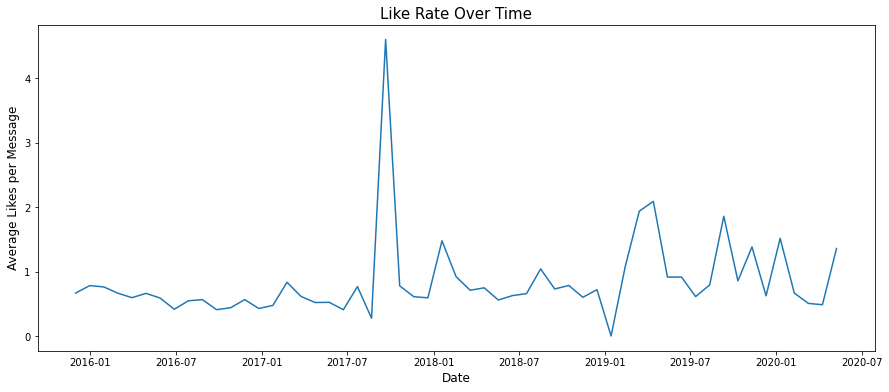

In [45]:
#PLOT: average likes per message
#This explains that Zander's low like rate is due to shitty messages, but still does not explain 
#Leo's abnormaly high rates

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.title("Like Rate Over Time", fontsize=15)
plt.ylabel("Average Likes per Message", fontsize=12)
plt.xlabel("Date", fontsize=12)

plt.plot(data['year_month'].value_counts().sort_index().index, list(like_rate.values()))
plt.show()

In [79]:
#What was going on 2017-09-21? Let's take a look
pd.set_option('max_colwidth', 2000)
data[data['year_month'] == pd.Timestamp(2017,9,21)][['text','like_count','true_name','attachments']]

#As suspected, complete garbage

,text,like_count,true_name,attachments
5386,None,8,Lucas,"[{'type': 'image', 'url': 'https://i.groupme.com/844x1500.jpeg.be0f401f04984a36b75a8bb5ee6d81ce'}]"
5387,why the fuck,0,Zander,[]
5388,The fact that all those jack-o-lanterns aren't all aligned is upsetting,4,Daniel,[]
5389,"It's COCKtober 🍆🎃 u know what that means 👀👅 Dick sucking awareness month 😯🙆🏼👅 send this to 12 of ur closet hoes 👭😈 that love that dick 🍆🍆🍆💦💦💦 🎃🎃🎃🎃🎃 🎃 🎃 🎃 🎃 🎃 🎃 🎃 🎃 🎃 🎃 🎃 🎃 🎃🎃🎃🎃🎃 🎃 🎃 🎃 🎃 🎃 🎃 🎃🎃🎃🎃 🎃 🎃 🎃 🎃 🎃 🎃 🎃 🎃 🎃 🎃 🎃🎃🎃🎃 🎃🎃🎃🎃🎃 🎃 🎃 🎃 🎃 🎃 🎃 THOT-O-WEEN 🎃is upon us !! If you get this message ✉️ you are queen 👸of the thots!!! Forward this to 7⃣ of the 🍆ThOtTiEsT🍆 thots 💁that you know will get some 👉👌 soon !!! If you don't, be prepared 🙍for 6⃣9⃣ days of bad luck ⚠️ 🍀",4,Ryan,[]
5390,@lucas,7,Stuart,"[{'type': 'image', 'url': 'https://i.groupme.com/504x360.jpeg.c9109aeb4f2d4c2d8389b619b344e0e9'}]"


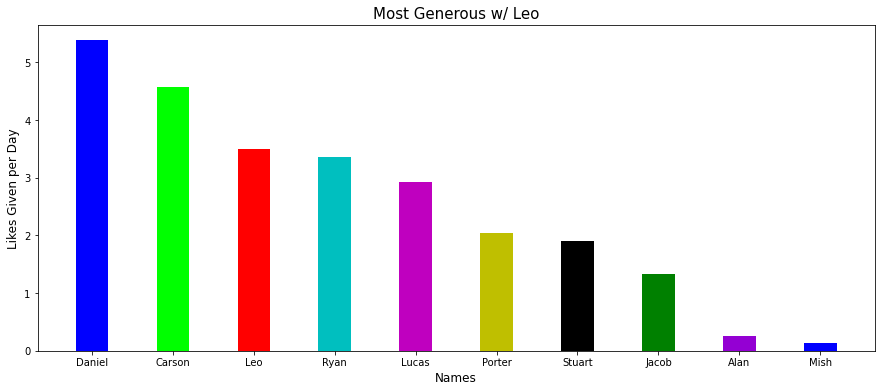

In [47]:
#Let's see how leo compares to everyone before 9/2016 when he was removed
import matplotlib.pyplot as plt


pre_rem = data[data['year_month'] < pd.Timestamp(2016,9,21)]
new_likes = {}
new_count = {}
pre_rem['favorited_by'].apply(lambda x: count_favs(x,new_count))

for name in pre_rem['true_name'].value_counts().index:
    if name != 'System':
        rows = pre_rem[pre_rem['true_name'] == name]
        new_likes[name] = new_count[name] / (pd.Timestamp(2016,9,21) - start_end[name][0]).days

plt.figure(figsize=(15, 6))
plt.title("Most Generous w/ Leo", fontsize=15)
plt.ylabel("Likes Given per Day", fontsize=12)
plt.xlabel("Names", fontsize=12)

new_likes = {k: v for k, v in sorted(new_likes.items(), key=lambda item: item[1], reverse=True)}

plt.bar(x=new_likes.keys(), height=new_likes.values(), width=.4, color=COLORS)
plt.show()

In [48]:
#One more - likes given per message sent in the group during the duration of the person

likes_message_sent = {}
for name in name_dict.keys():
    if name == 'System':
        continue
    
    like_count = {}
    #get duration 
    rows = data[(data['year_month'] > start_end[name][0]) & (data['year_month'] < start_end[name][1])]
    rows['favorited_by'].apply(lambda x: count_favs(x, like_count))
    total_sent = len(rows[rows['true_name']!=name].index)
    
    
    likes_message_sent[name] = like_count[name] / total_sent
    
likes_message_sent
    
    


{'Porter': 0.06658672052511992,
 'Stuart': 0.06067107694141487,
 'Lucas': 0.08180158247108947,
 'Zander': 0.13116828342471532,
 'Ryan': 0.09923815833057303,
 'Alan': 0.008427267847557703,
 'Carson': 0.11278007259982475,
 'Max': 0.03156434269857787,
 'Mish': 0.0028381181093767058,
 'Will': 0.04834254143646409,
 'Jacob': 0.034057755284310806,
 'Daniel': 0.15276257207503102,
 'Isaac': 0.004531294250920419,
 'Leo': 0.09912686183872625}

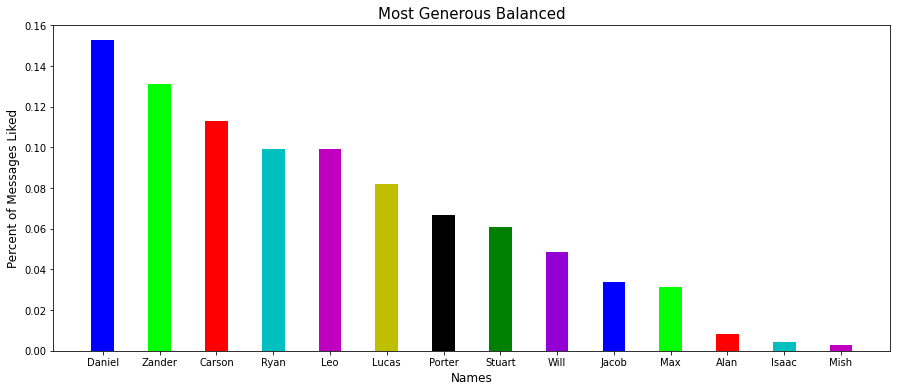

In [50]:
#Now plot the results 
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.title("Most Generous Balanced", fontsize=15)
plt.ylabel("Percent of Messages Liked", fontsize=12)
plt.xlabel("Names", fontsize=12)

likes_message_sent = {k: v for k, v in sorted(likes_message_sent.items(), key=lambda item: item[1], reverse=True)}

plt.bar(x=likes_message_sent.keys(), height=likes_message_sent.values(), width=.4, color=COLORS)
plt.show()

#### Like Correlations
- Which people like similar things?

In [51]:
#Creating some new additions to liked_messaged
liked_messages['favorited_by'] = liked_messages['favorited_by'].apply(lambda x: [id_to_name[y] for y in x])

for name in name_dict.keys():
    if name == 'System':
        continue
    
    liked_messages[name+'_liked'] = liked_messages['favorited_by'].apply(lambda x: name in x)
liked_messages

,text,like_count,true_name,attachments,in_chat,num_active,favorited_by,year_month,created_at,percent_like,...,Ryan_liked,Alan_liked,Carson_liked,Max_liked,Mish_liked,Will_liked,Jacob_liked,Daniel_liked,Isaac_liked,Leo_liked
2848,"We love you man, hang in there",9,Carson,[],"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Daniel, Isaac, Lucas, Ryan, Jacob, Zander, Porter, Will, Max]",2018-09-16,2018-09-23 04:35:33,0.692308,...,True,False,False,True,False,True,True,True,True,False
2381,@Carson you look handsome in that yearbook pic,9,Jacob,"[{'loci': [[0, 7]], 'type': 'mentions', 'user_ids': ['25419093']}]","[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Lucas, Alan, Ryan, Stuart, Zander, Porter, Will, Carson, Max]",2019-03-15,2019-03-22 15:45:09,0.692308,...,True,True,True,True,False,True,False,False,False,False
4194,im a yellow jacket now,9,Porter,[],"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Daniel, Isaac, Lucas, Stuart, Zander, Mish, Will, Carson, Max]",2018-05-19,2018-06-01 21:07:20,0.692308,...,False,False,True,True,True,True,False,True,True,False
7239,tfw,9,Daniel,"[{'type': 'image', 'url': 'https://i.groupme.com/722x1280.jpeg.cfdb63b390b24f55998be4974aa75732'}]","[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mish, Will, Jacob, Daniel]",10,"[Daniel, Lucas, Alan, Ryan, Stuart, Jacob, Porter, Will, Carson]",2017-02-23,2017-03-11 16:35:40,0.900000,...,True,True,True,False,False,True,True,True,False,False
2378,Spotted at Lenox https://v.groupme.com/18315642/2019-05-05T18:43:21Z/1edbc4b.568x320r90.mp4,9,Porter,"[{'preview_url': 'https://v.groupme.com/18315642/2019-05-05T18:43:21Z/1edbc4b.568x320r90.jpg', 'type': 'video', 'url': 'https://v.groupme.com/18315642/2019-05-05T18:43:21Z/1edbc4b.568x320r90.mp4'}]","[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Daniel, Isaac, Lucas, Ryan, Jacob, Zander, Will, Carson, Max]",2019-04-14,2019-05-05 18:43:32,0.692308,...,True,False,True,True,False,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10943,We add the class,1,Lucas,[],"[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mish, Jacob, Daniel, Leo]",10,[Daniel],2016-07-28,2016-08-16 15:23:54,0.100000,...,False,False,False,False,False,False,False,True,False,False
10941,I like looking at everyone's profile pictures,1,Carson,[],"[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mish, Jacob, Daniel, Leo]",10,[Ryan],2016-07-28,2016-08-16 15:32:16,0.100000,...,True,False,False,False,False,False,False,False,False,False
10937,Stuart bring your car and put it on stage,1,Lucas,[],"[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mish, Jacob, Daniel, Leo]",10,[Ryan],2016-07-28,2016-08-16 16:21:26,0.100000,...,True,False,False,False,False,False,False,False,False,False
10928,They saw the freshman getting harassed by seniors but no one... Said anything,1,Ryan,[],"[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mish, Jacob, Daniel, Leo]",10,[Carson],2016-07-28,2016-08-16 16:23:17,0.100000,...,False,False,True,False,False,False,False,False,False,False


In [52]:
bool_likes = liked_messages[['Daniel_liked', 'Stuart_liked', 'Leo_liked', 'Porter_liked', 'Zander_liked', 
               'Alan_liked', 'Lucas_liked', 'Will_liked', 'Mish_liked', 'Ryan_liked', 'Carson_liked', 
                             'Jacob_liked','Max_liked','Isaac_liked', 'year_month']]
names = ['Daniel_liked', 'Stuart_liked', 'Leo_liked', 'Porter_liked', 'Zander_liked', 
               'Alan_liked', 'Lucas_liked', 'Will_liked', 'Mish_liked', 'Ryan_liked', 'Carson_liked', 
                             'Jacob_liked','Max_liked','Isaac_liked']
names = [name.replace('_liked','') for name in names]

In [53]:
print(len(bool_likes[bool_likes['Daniel_liked'] == False]))

4350


In [54]:
for name in name_dict.keys():
    if name == 'System':
        continue
    
    bool_likes[name+'_liked'] = bool_likes[name+'_liked'].map({True:1, False:-1})
bool_likes.head()

/home/davon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Daniel_liked,Stuart_liked,Leo_liked,Porter_liked,Zander_liked,Alan_liked,Lucas_liked,Will_liked,Mish_liked,Ryan_liked,Carson_liked,Jacob_liked,Max_liked,Isaac_liked,year_month
2848,1,-1,-1,1,1,-1,1,1,-1,1,-1,1,1,1,2018-09-16
2381,-1,1,-1,1,1,1,1,1,-1,1,1,-1,1,-1,2019-03-15
4194,1,1,-1,-1,1,-1,1,1,1,-1,1,-1,1,1,2018-05-19
7239,1,1,-1,1,-1,1,1,1,-1,1,1,1,-1,-1,2017-02-23
2378,1,-1,-1,-1,1,-1,1,1,-1,1,1,1,1,1,2019-04-14


In [82]:
from sklearn.metrics import matthews_corrcoef

def get_binary_distance(func, bool_likes):
    like_arr = np.zeros(shape=((len(bool_likes.columns)-1), len(bool_likes.columns)-1))
    replace_string = '_liked'
    
    for i in range(len(bool_likes.columns)-1):
        for j in range(len(bool_likes.columns)-1):
            
            i_name = bool_likes.columns[i].replace('_liked','')
            j_name = bool_likes.columns[j].replace('_liked','')
    #         print(i_name, j_name)
            #Now for each person get their overlapping time frame 
            i_start = start_end[i_name][0]
            j_start = start_end[j_name][0]

            i_end = start_end[i_name][1]
            j_end = start_end[j_name][1]

            start =  i_start if i_start > j_start else j_start
            end = i_end if i_end <= j_end else j_end

            rows = bool_likes[(bool_likes['year_month'] >= start) & (bool_likes['year_month'] < end)]

            i_vector = rows.iloc[:,i]
            j_vector = rows.iloc[:,j]

            corr = func(list(i_vector), list(j_vector))
            like_arr[i, j] = 1 - corr
            
    return like_arr
        
    

In [100]:
def get_binary_distance_2(func, bool_likes):
    like_arr = np.zeros(shape=((len(bool_likes.columns)-1), len(bool_likes.columns)-1))
    replace_string = '_liked'
    
    for i in range(len(bool_likes.columns)-1):
        for j in range(len(bool_likes.columns)-1):
            
            i_name = bool_likes.columns[i].replace('_liked','')
            j_name = bool_likes.columns[j].replace('_liked','')
    #         print(i_name, j_name)
            #Now for each person get their overlapping time frame 
            i_start = start_end[i_name][0]
            j_start = start_end[j_name][0]

            i_end = start_end[i_name][1]
            j_end = start_end[j_name][1]

            start =  i_start if i_start > j_start else j_start
            end = i_end if i_end <= j_end else j_end

            rows = bool_likes[(bool_likes['year_month'] >= start) & (bool_likes['year_month'] < end) & 
                              ((bool_likes[i_name+'_liked'] != -1) | (bool_likes[j_name+'_liked'] != -1))]

            i_vector = rows.iloc[:,i]
            j_vector = rows.iloc[:,j]

            corr = func(list(i_vector), list(j_vector))
            like_arr[i, j] = 1 - corr
                
    return like_arr

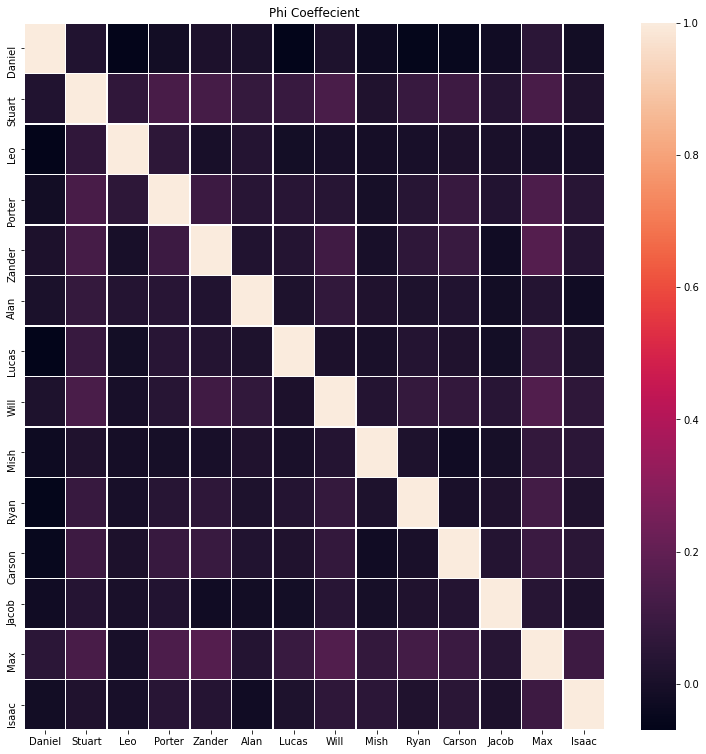

In [61]:
import matplotlib.pyplot as plt

like_arr = get_binary_distance(matthews_corrcoef)
plt.figure(figsize=(13, 13))
plt.title("Phi Coeffecient")
ax = sns.heatmap(like_arr, linewidth=0.5, xticklabels=names, yticklabels=names)
plt.show()

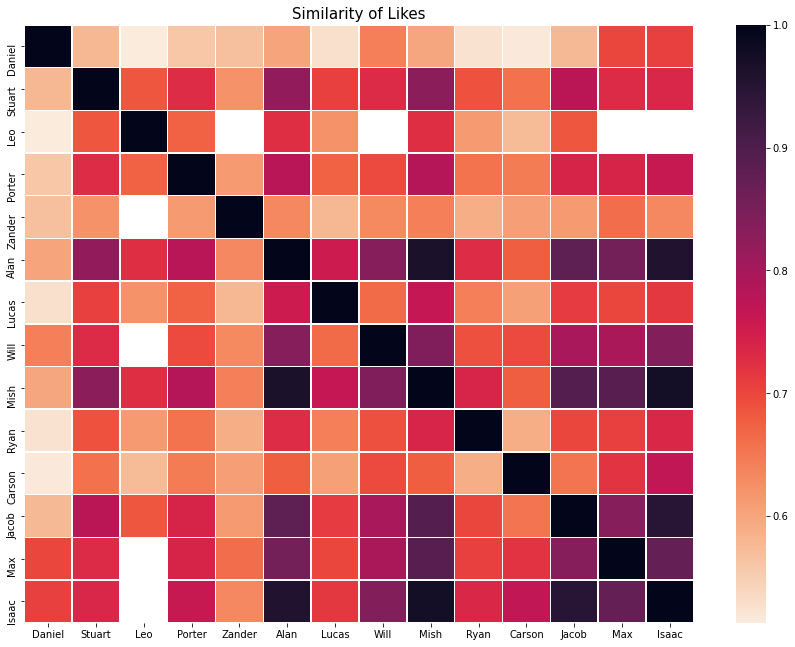

In [85]:
from scipy.spatial.distance import hamming

like_arr = get_binary_distance(hamming, bool_likes)
plt.figure(figsize=(15, 11))
plt.title("Similarity of Likes", fontsize=15)
ax = sns.heatmap(like_arr, linewidth=0.5, xticklabels=names, yticklabels=names, cmap = sns.cm.rocket_r)
plt.show()

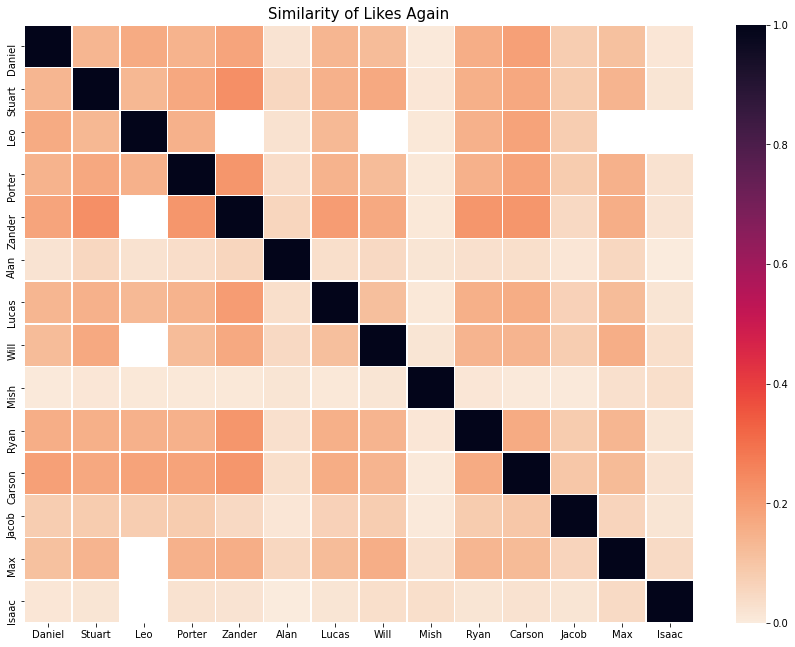

In [101]:
from scipy.spatial.distance import hamming

like_arr = get_binary_distance_2(hamming, bool_likes)
plt.figure(figsize=(15, 11))
plt.title("Similarity of Likes Again", fontsize=15)
ax = sns.heatmap(like_arr, linewidth=0.5, xticklabels=names, yticklabels=names, cmap = sns.cm.rocket_r)
plt.show()

### Birthdays
- Whose birthday was missed
- Whose birthday got the most likes 

In [66]:
#I'm not going to bother with proper birthday dates, just mentions every year
#First, let's try and get the birthday messages - this could be tricky

#Let's get the liked_messages, since odds are someone has liked them
bday_messages = liked_messages[liked_messages['text'] != None]
bday_messages = liked_messages.dropna(subset=['text'])
bday_messages[bday_messages['text'].str.contains('birthday') | bday_messages['text'].str.contains('bday') | bday_messages['text'].str.contains('hbd') | 
              bday_messages['text'].str.contains('21') | ]

,text,like_count,true_name,attachments,in_chat,num_active,favorited_by,year_month,created_at
2378,Spotted at Lenox https://v.groupme.com/18315642/2019-05-05T18:43:21Z/1edbc4b.568x320r90.mp4,9,Porter,"[{'preview_url': 'https://v.groupme.com/18315642/2019-05-05T18:43:21Z/1edbc4b.568x320r90.jpg', 'type': 'video', 'url': 'https://v.groupme.com/18315642/2019-05-05T18:43:21Z/1edbc4b.568x320r90.mp4'}]","[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Daniel, Isaac, Lucas, Ryan, Jacob, Zander, Will, Carson, Max]",2019-04-14,2019-05-05 18:43:32
5014,Happy birthday? @Daniel,8,Ryan,"[{'loci': [[16, 7]], 'type': 'mentions', 'user_ids': ['19090345']}]","[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Daniel, Lucas, Stuart, Zander, Porter, Will, Carson, Max]",2017-12-20,2018-01-06 22:37:44
4592,Happy birthday yung boy Z,8,Stuart,[],"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Daniel, Lucas, Ryan, Zander, Porter, Will, Carson, Max]",2018-04-19,2018-05-08 06:14:28
2352,happy birthday ike @Isaac Sencer,8,Zander,"[{'loci': [[19, 13]], 'type': 'mentions', 'user_ids': ['19090349']}]","[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Daniel, Lucas, Ryan, Stuart, Porter, Will, Carson, Max]",2019-04-14,2019-05-13 00:07:33
4483,@Isaac Sencer hbd man,8,Zander,"[{'loci': [[0, 13]], 'type': 'mentions', 'user_ids': ['19090349']}]","[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Daniel, Lucas, Ryan, Stuart, Porter, Will, Carson, Max]",2018-04-19,2018-05-12 04:58:44
2238,Happy birthday Stuart,7,Will,[],"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel]",12,"[Lucas, Ryan, Stuart, Zander, Porter, Carson, Max]",2019-05-14,2019-06-08 16:10:03
4036,hbd man @Stuart Duffield,7,Zander,[],"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Daniel, Lucas, Stuart, Mish, Porter, Will, Max]",2018-05-19,2018-06-08 15:28:20
4914,Happy birthday Max,7,Porter,[],"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Daniel, Lucas, Ryan, Stuart, Zander, Will, Max]",2018-01-19,2018-02-16 21:15:08
4929,Happy birthday yung dan and port,7,Stuart,[],"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Daniel, Ryan, Zander, Porter, Will, Carson, Max]",2018-01-19,2018-02-04 17:25:05
10432,Happy birthday buddy! 💦 @Ryan,7,Alan,"[{'loci': [[25, 5]], 'type': 'mentions', 'user_ids': ['22491676']}]","[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mish, Jacob, Daniel, Leo]",10,"[Daniel, Leo, Ryan, Stuart, Jacob, Porter, Carson]",2016-08-27,2016-09-20 17:23:58


In [68]:
#Still can't find lucas
bday_messages = liked_messages.dropna(subset=['text'])
bday_messages[bday_messages['text'].str.contains('alan') | bday_messages['text'].str.contains('Alan')]

,text,like_count,true_name,attachments,in_chat,num_active,favorited_by,year_month,created_at
4949,@Alan Visoso I'm sorry to hear that man,7,Stuart,"[{'loci': [[0, 12]], 'type': 'mentions', 'user_ids': ['19844543']}]","[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Daniel, Lucas, Alan, Ryan, Zander, Porter, Will]",2017-12-20,2018-01-14 20:50:18
523,Alan's immune system gonna be in 2040 soon enough,6,Stuart,[],"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob]",11,"[Lucas, Alan, Ryan, Jacob, Zander, Carson]",2020-03-09,2020-03-27 18:26:01
19989,Alan Visoso has rejoined the group,4,System,[],"[Stuart, Lucas, Ryan, Alan, Carson, Mish, Jacob, Daniel, Leo]",9,"[Leo, Ryan, Stuart, Carson]",2015-12-01,2015-12-23 16:41:22
16311,Alan listening to bocelli and pulling the fuck out of these sophomores without even trying,4,Ryan,"[{'type': 'image', 'url': 'https://i.groupme.com/1280x960.jpeg.120102e7350945499bd74ce9ec40e50a'}]","[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mish, Jacob, Daniel, Leo]",10,"[Daniel, Alan, Leo, Stuart]",2016-01-30,2016-02-12 19:06:55
10208,"@Alan Visoso yeah, I'm sorry man. I keep thinking about that. I feel like a person of Hispanic heritage who hears this is equivalent to me listening to Hitler speak in Germany in the 30's",4,Jacob,"[{'loci': [[0, 12]], 'type': 'mentions', 'user_ids': ['19844543']}]","[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mish, Jacob, Daniel, Leo]",10,"[Daniel, Alan, Leo, Carson]",2016-09-26,2016-10-10 01:50:46
14701,@Alan Visoso 😍😍😍💦💦💦💦💦💦,4,Leo,"[{'type': 'image', 'url': 'https://i.groupme.com/722x1280.jpeg.28a2f57773534ac08988252738fe87b2'}, {'loci': [[0, 12]], 'type': 'mentions', 'user_ids': ['19844543']}]","[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mish, Jacob, Daniel, Leo]",10,"[Daniel, Lucas, Alan, Porter]",2016-02-29,2016-03-20 23:12:31
11875,Alan doesn't hang with us and he's in,3,Lucas,[],"[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mish, Jacob, Daniel, Leo]",10,"[Daniel, Leo, Carson]",2016-05-29,2016-06-10 19:15:30
1767,Jacob Alan Ryan max let’s run 5s at the Y sometime this break,3,Lucas,[],"[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob]",11,"[Ryan, Jacob, Max]",2019-12-10,2019-12-21 18:41:24
3817,And @Mish and @Alan where have y'all been at,3,Stuart,"[{'loci': [[4, 5], [14, 5]], 'type': 'mentions', 'user_ids': ['25075271', '19844543']}]","[Porter, Stuart, Lucas, Zander, Ryan, Alan, Carson, Max, Mish, Will, Jacob, Daniel, Isaac]",13,"[Lucas, Alan, Ryan]",2018-06-18,2018-06-19 02:30:15
7924,@Alan Visoso First of all I don't say that. Second of all I support legalization of drugs.,2,Lucas,"[{'loci': [[0, 12]], 'type': 'mentions', 'user_ids': ['19844543']}]","[Porter, Stuart, Lucas, Ryan, Alan, Carson, Mish, Jacob, Daniel]",9,"[Ryan, Porter]",2016-12-25,2017-01-21 19:19:06


In [69]:
#(month, day)
birthdays = {
    'Zander' : (5, 8),
    'Daniel' : (1, 6),
    'Isaac'  : (5, 12),
    'Stuart' : (6, 8),
    'Max'    : (2, 16),
    'Porter' : (2, 4),
    'Ryan'   : (9, 20),
    'Carson' : (7, 1),
    'Will'   : (4, 16),
    'Lucas'  : (1, 12)
}

In [70]:
def contains_birthday_mention(text):
    text = text.lower()
    return (text.contains('birthday') or text.contains('bday') or text.contains('hbd') 
or text.contains('21') or text.contains('20') or text.contains('19') or text.cotains('18'))

In [ ]:
#Let's average these outa

### NLP (Natural Language Processing)
- Getting the most frequent words per person
- Average length of text message
- Person that said 'X' the most
- Maybe some sentiment analysis as well
- "What goes into a liked message"

In [39]:

words = data[['text', 'true_name']]
words['text'] = words['text'].str.lower()
words['text'] = words['text'].dropna()
print(words)
stop = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

words['core'] = words['text'].apply(lambda x: ' '.join([item for item in x.split(' ') if item not in stop]) if isinstance(x, str) else [])
words

/home/davon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/davon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


                                                    text true_name
0                                          hang tonight?    Porter
1                                              scroll up    Stuart
2                                                    neg     Lucas
3                                     porter are you nrg     Lucas
4      yeah im carded like half the time which makes ...     Lucas
...                                                  ...       ...
21489                                 that's pretty dumb    Daniel
21490                @lucas mavromatis needs to make his      Ryan
21491  because we're doing group mes for each of our ...      Ryan
21492     i still don't understand why this is necessary    Daniel
21493                                 starting w the men      Ryan

[21135 rows x 2 columns]


/home/davon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,text,true_name,core
0,hang tonight?,Porter,hang tonight?
1,scroll up,Stuart,scroll
2,neg,Lucas,neg
3,porter are you nrg,Lucas,porter nrg
4,yeah im carded like half the time which makes ...,Lucas,yeah im carded like half time makes think trie...
...,...,...,...
21489,that's pretty dumb,Daniel,that's pretty dumb
21490,@lucas mavromatis needs to make his,Ryan,@lucas mavromatis needs make
21491,because we're doing group mes for each of our ...,Ryan,we're group mes friends
21492,i still don't understand why this is necessary,Daniel,still understand necessary


In [41]:
from collections import Counter

Counter(" ".join(words["core"]).split(' ')).most_common(100)

TypeError: sequence item 68: expected str instance, list found